In [1]:
!pip install datasets transformers
!pip install fvcore
!pip install -U zetascale

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.2 MB

In [61]:
import torch
import torch.nn.functional as F
from torch import Tensor, nn
import subprocess
import time
import matplotlib.pyplot as plt
from zeta.nn import *  # noqa: F403, E402
from fvcore.nn import FlopCountAnalysis, flop_count

from zeta.nn import FeedForward, MultiQueryAttention

avg_power = [0] * 3
avg_flops = [0] * 3
num_passes= 0

class SwitchGate(nn.Module):
    """
    SwitchGate module for MoE (Mixture of Experts) model.

    Args:
        dim (int): Input dimension.
        num_experts (int): Number of experts.
        capacity_factor (float, optional): Capacity factor for sparsity. Defaults to 1.0.
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.
    """

    def __init__(
        self,
        dim,
        num_experts: int,
        capacity_factor: float = 1.0,
        epsilon: float = 1e-6,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.dim = dim
        self.num_experts = num_experts
        self.capacity_factor = capacity_factor
        self.epsilon = epsilon
        self.w_gate = nn.Linear(dim, num_experts)

    def forward(self, x: Tensor, use_aux_loss=False):
        """
        Forward pass of the SwitchGate module.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Gate scores.
        """
        # Compute gate scores
        gate_scores = F.softmax(self.w_gate(x), dim=-1)
        #print(gate_scores)

        # Determine the top-1 expert for each token
        capacity = int(self.capacity_factor * x.size(0))

        #top_k_scores, top_k_indices = gate_scores.topk(1, dim=-1)

        # # Mask to enforce sparsity
        # #mask = torch.zeros_like(gate_scores).scatter_(
        #     1, top_k_indices, 1
        # )

        # Combine gating scores with the mask
        # masked_gate_scores = gate_scores * mask

        # Denominators
        denominators = (
            gate_scores.sum(0, keepdim=True) + self.epsilon
        )

        # Norm gate scores to sum to the capacity
        gate_scores = (gate_scores / denominators) * capacity

        if use_aux_loss:
            load = gate_scores.sum(0)  # Sum over all examples
            importance = gate_scores.sum(1)  # Sum over all experts

            # Aux loss is mean suqared difference between load and importance
            loss = ((load - importance) ** 2).mean()

            return gate_scores, loss

        return gate_scores, None


class SwitchMoE(nn.Module):
    """
    A module that implements the Switched Mixture of Experts (MoE) architecture.

    Args:
        dim (int): The input dimension.
        hidden_dim (int): The hidden dimension of the feedforward network.
        output_dim (int): The output dimension.
        num_experts (int): The number of experts in the MoE.
        capacity_factor (float, optional): The capacity factor that controls the capacity of the MoE. Defaults to 1.0.
        mult (int, optional): The multiplier for the hidden dimension of the feedforward network. Defaults to 4.
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.

    Attributes:
        dim (int): The input dimension.
        hidden_dim (int): The hidden dimension of the feedforward network.
        output_dim (int): The output dimension.
        num_experts (int): The number of experts in the MoE.
        capacity_factor (float): The capacity factor that controls the capacity of the MoE.
        mult (int): The multiplier for the hidden dimension of the feedforward network.
        experts (nn.ModuleList): The list of feedforward networks representing the experts.
        gate (SwitchGate): The switch gate module.


    """
    def get_gpu_power(self):
        # Use nvidia-smi to get the current power draw (in watts)
        try:
            power_info = subprocess.check_output(['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits'])
            power_draw = float(power_info.strip())  # Power in watts (W)
            return power_draw
        except Exception as e:
            print("Error getting GPU power:", e)
            return 0

    def __init__(
        self,
        dim: int,
        hidden_dim: int,
        output_dim: int,
        num_experts: int,
        capacity_factor: float = 1.0,
        mult: int = 4,
        use_aux_loss: bool = False,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_experts = num_experts
        self.capacity_factor = capacity_factor
        self.mult = mult
        self.use_aux_loss = use_aux_loss
        self.start_time = None
        self.end_time = None
        self.experts = nn.ModuleList(
            [
                FeedForward(dim, dim, mult, *args, **kwargs)
                for _ in range(num_experts)
            ]
        )

        self.gate = SwitchGate(
            dim,
            num_experts,
            capacity_factor,
        )

        self.flops_tracker = torch.zeros(num_experts, dtype=torch.float32)
        self.total_batches = 0
        self.flops_for_batch = {i: 0 for i in range(self.num_experts)}  # FLOPs for the current batch
        self.energy_per_flop = 1e-12

        #self.power_tracker = [0.0] * num_experts

        self.power_tracker = torch.zeros(num_experts, dtype=torch.float32)
        self.flops_per_expert = []
        self.energy_per_expert = []


    def plot_flops_vs_energy(self,total_energy):
      num_experts = len(self.flops_tracker)

    # Compute average FLOPs and energy for each expert
      average_flops_per_expert = self.flops_tracker / self.total_batches


    # Create the plot
      plt.figure(figsize=(10, 6))

    # Plot each expert's FLOPs vs Energy individually
      for i in range(num_experts):
        plt.plot(average_flops_per_expert[i].cpu().numpy(),
                 total_energy[i].cpu().numpy(),
                 'o-', label=f"Expert {i}")

    # Add labels and title
      plt.xlabel("FLOPs (gFLOPs)")
      plt.ylabel("Energy Expenditure (Joules)")
      plt.title("FLOPs vs Energy Expenditure for Each Expert")
      plt.grid(True)
      plt.legend()
      plt.show()

    def forward(self, x: Tensor,energy_data=None):
      gate_scores, loss = self.gate(x)

      initial_power = self.get_gpu_power()


      batch_size, seq_len, num_experts = gate_scores.size()

    # Get the top expert index for each token
      top_k_scores, top_k_indices = gate_scores.topk(1, dim=-1)  # top_k_indices is of shape (batch_size, seq_len, 1)

    # Flatten for easier manipulation
      x_flat = x.view(-1, x.size(-1))  # Flatten to (batch_size * seq_len, dim)
      top_k_indices_flat = top_k_indices.view(-1)  # Flatten to (batch_size * seq_len,)

    # Prepare outputs storage
      selected_expert_outputs = torch.zeros(batch_size * seq_len, x.size(-1), device=x.device)
      expert_weights = torch.zeros(batch_size * seq_len, device=x.device)
      #selected_expert_outputs = torch.zeros_like(x_flat)

      total_flops = torch.zeros(num_experts, device=x.device)
      total_energy = torch.zeros(num_experts, device=x.device)

      total_flops = 0


    # Process each expert independently

      for i in range(num_experts):
        # Get tokens assigned to this expert
        expert_mask = (top_k_indices_flat == i).nonzero(as_tuple=True)[0]
        #expert_mask = torch.arange(x_flat.size(0), device=x.device) #uncomment this line and comment out the above to use K>1

        if expert_mask.numel() > 0:
            tokens_for_expert = x_flat[expert_mask]
            # Compute expert output for these tokens
            self.start_time = time.time()
            expert_output = self.experts[i](tokens_for_expert)
            final_power = self.get_gpu_power()
            self.end_time = time.time()

            total_time= self.end_time - self.start_time

            flops,_ = flop_count(self.experts[i],(tokens_for_expert,))
            expert_flops = sum(flops.values())
            self.flops_tracker[i] += expert_flops

            total_energy[i] += final_power * total_time  # Energy in joules


            # Store the expert output in the corresponding positions
            #selected_expert_outputs.index_add_(0, expert_mask, expert_output)
            weights = top_k_scores.view(-1)[expert_mask]
            expert_weights[expert_mask] = weights.squeeze()

            # Store the expert output in the corresponding positions
            selected_expert_outputs.index_add_(0, expert_mask, expert_output * weights.unsqueeze(1))


    # Reshape the selected expert outputs back to (batch_size, seq_len, dim)
      moe_output = selected_expert_outputs.view(batch_size, seq_len, -1)
      self.total_batches += 1

      average_flops_per_expert = self.flops_tracker / self.total_batches
      avg_energy = total_energy / self.total_batches

      total_energy = total_energy / self.total_batches

      flops_per_layer = 0


      for i in range(num_experts):
         print(f"  Expert {i}: {avg_energy[i]:.4f} J")
         print(f"  Expert {i}: {average_flops_per_expert[i]:.4f} gFlops")
         flops_per_layer += average_flops_per_expert[i]
      self.plot_flops_vs_energy(avg_energy)

      return moe_output, loss,flops_per_layer

#moe_output = torch.stack(expert_outputs, dim=0).sum(dim=0)
class SwitchTransformerBlock(nn.Module):
    """
    SwitchTransformerBlock is a module that represents a single block of the Switch Transformer model.

    Args:
        dim (int): The input dimension of the block.
        heads (int): The number of attention heads.
        dim_head (int): The dimension of each attention head.
        mult (int, optional): The multiplier for the hidden dimension in the feed-forward network. Defaults to 4.
        dropout (float, optional): The dropout rate. Defaults to 0.1.
        depth (int, optional): The number of layers in the block. Defaults to 12.
        num_experts (int, optional): The number of experts in the SwitchMoE layer. Defaults to 6.
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.

    Attributes:
        dim (int): The input dimension of the block.
        heads (int): The number of attention heads.
        dim_head (int): The dimension of each attention head.
        mult (int): The multiplier for the hidden dimension in the feed-forward network.
        dropout (float): The dropout rate.
        attn_layers (nn.ModuleList): List of MultiQueryAttention layers.
        ffn_layers (nn.ModuleList): List of SwitchMoE layers.

    Examples:
        >>> block = SwitchTransformerBlock(dim=512, heads=8, dim_head=64)
        >>> x = torch.randn(1, 10, 512)
        >>> out = block(x)
        >>> out.shape

    """

    def __init__(
        self,
        dim: int,
        heads: int,
        dim_head: int,
        mult: int = 4,
        dropout: float = 0.1,
        num_experts: int = 3,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.dim_head = dim_head
        self.mult = mult
        self.dropout = dropout

        self.attn = MultiQueryAttention(
            dim, heads, qk_ln=True * args, **kwargs
        )

        self.ffn = SwitchMoE(
            dim, dim * mult, dim, num_experts, *args, **kwargs
        )

        self.add_norm = nn.LayerNorm(dim)

    def forward(self, x: Tensor):
        """
        Forward pass of the SwitchTransformerBlock.

        Args:
            x (Tensor): The input tensor.

        Returns:
            Tensor: The output tensor.

        """
        resi = x
        x, _, _ = self.attn(x)
        attnflops,_ = flop_count(self.attn,(x,))
        x = x + resi
        x = self.add_norm(x)
        normflops,_ = flop_count(self.add_norm,(x,))
        add_normed = x

        ##### MoE #####
        x, _ ,ffn_flops= self.ffn(x)
        x = x + add_normed
        x = self.add_norm(x)
        total_flops = sum(attnflops.values()) + sum(normflops.values()) + ffn_flops.item()

        return x,total_flops

class LearnedPositionalEmbedding(nn.Module):
    def __init__(self, max_len: int, embed_dim: int):
        super().__init__()
        self.position_embeddings = nn.Embedding(max_len, embed_dim)

    def forward(self, x: Tensor):
        # x is expected to be of shape (batch_size, seq_len)
        batch_size, seq_len = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        return self.position_embeddings(positions)


class SwitchTransformer(nn.Module):
    """
    SwitchTransformer is a PyTorch module that implements a transformer model with switchable experts.

    Args:
        num_tokens (int): The number of tokens in the input vocabulary.
        dim (int): The dimensionality of the token embeddings and hidden states.
        heads (int): The number of attention heads.
        dim_head (int, optional): The dimensionality of each attention head. Defaults to 64.
        mult (int, optional): The multiplier for the hidden dimension in the feed-forward network. Defaults to 4.
        dropout (float, optional): The dropout rate. Defaults to 0.1.
        num_experts (int, optional): The number of experts in the switchable experts mechanism. Defaults to 3.
        *args: Additional positional arguments.
        **kwargs: Additional keyword arguments.


    """

    def __init__(
        self,
        num_tokens: int,
        dim: int,
        heads: int,
        dim_head: int = 64,
        mult: int = 4,
        dropout: float = 0.1,
        num_experts: int = 3,
        depth: int = 4,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.num_tokens = num_tokens
        self.dim = dim
        self.heads = heads
        self.dim_head = dim_head
        self.mult = mult
        self.dropout = dropout
        self.num_experts = num_experts
        self.depth = depth
        self.sequence_length= 256

        self.embedding = nn.Embedding(num_tokens, dim)
        self.position_embeddings = nn.Embedding(self.sequence_length, dim)
        self.layers = nn.ModuleList([])
        self.start_time = None

        for _ in range(depth):
            self.layers.append(
                SwitchTransformerBlock(
                    dim,
                    heads,
                    dim_head,
                    mult,
                    dropout,
                    num_experts,
                    *args,
                    **kwargs,
                )
            )

        self.to_out = nn.Sequential(
            nn.Softmax(dim=-1),
            nn.LayerNorm(dim),
            nn.Linear(dim, num_tokens),
        )
    def get_gpu_power(self):
        # Use nvidia-smi to get the current power draw (in watts)
        try:

            power_info = subprocess.check_output(['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits'])
            power_draw = float(power_info.strip())  # Power in watts (W)
            return power_draw
        except Exception as e:
            print("Error getting GPU power:", e)
            return 0

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the SwitchTransformer.

        Args:
            x (Tensor): The input tensor of shape (batch_size, sequence_length).

        Returns:
            Tensor: The output tensor of shape (batch_size, sequence_length, num_tokens).
        """
        # Embed tokens through embedding layer

        x = x.long()




        x = self.embedding(x)

        positions = torch.arange(self.sequence_length, device=x.device).unsqueeze(0).expand(batch_size, -1)
        pEmbed= self.position_embeddings(positions)
        x = x + pEmbed

        flops=[]
        i=1

        initial_power = self.get_gpu_power()

        # Pass through the transformer block with MoE, it's in modulelist
        for layer in self.layers:
            print("Layer ",i)
            i+=1

            self.start_time = time.time()
            x,ffn_flops= layer(x)
            final_power = self.get_gpu_power()
            end_time = time.time()
            elapsed_time = end_time - self.start_time
            energy_in_joules = final_power * elapsed_time
            print("Layer", i , "Energy in joules: ", energy_in_joules)
            flops.append(ffn_flops)



        # Project to output tokens
        x = self.to_out(x)




        for i in range(len(flops)):
              flops_val = flops[i]
              print(f"Layer {i+1} Gflops: {flops_val}")

        return x,flops

In [2]:
!apt-get install git-lfs
!git lfs install
!GIT_LFS_SKIP_SMUDGE=1 git clone https://huggingface.co/datasets/allenai/c4
%cd c4
!git lfs pull --include "en/c4-train.00000-of-01024.json.gz"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Git LFS initialized.
Cloning into 'c4'...
remote: Enumerating objects: 87108, done.
remote: Total 87108 (delta 0), reused 0 (delta 0), pack-reused 87108 (from 1)
Receiving objects: 100% (87108/87108), 12.30 MiB | 14.46 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Updating files: 100% (69221/69221), done.
/content/c4


In [51]:
from datasets import load_dataset

from transformers import T5TokenizerFast, T5Tokenizer

import gzip
import json

def load_json_gz(filepath):
    with gzip.open(filepath, 'rb') as f:
        for line in f:
            yield json.loads(line)

# Load the small subset you downloaded
dataset_path = 'en/c4-train.00000-of-01024.json.gz'
data = list(load_json_gz(dataset_path))

# Preview a few examples
print(data[:2])

# Load the fast version of the T5 tokenizer
#tokenizer = T5TokenizerFast.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained('t5-small', use_fast=True)
# Load the C4 dataset
tokenized_data = [tokenizer.encode(d['text'], return_tensors='pt') for d in data[:100]]

#tokenized_data.set_format(type="torch", columns=["input_ids"])

[{'text': 'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.', 'timestamp': '2019-04-25T12:57:54Z', 'url': 'https://klyq.com/beginners-bbq-class-taking-place-in-missoula/'}, {'text': 'Discussion in \'Mac OS X Lion (10.7)\' started by axboi87, Jan 20, 2012.\nI\'ve got a 500gb internal drive and a 24

Token indices sequence length is longer than the specified maximum sequence length for this model (2600 > 512). Running this sequence through the model will result in indexing errors


100
NUM_TOKENS  32000
Layer  1
  Expert 0: 0.5610 J
  Expert 0: 3.8839 gFlops
  Expert 1: 0.9008 J
  Expert 1: 2.2838 gFlops
  Expert 2: 0.7676 J
  Expert 2: 2.4222 gFlops


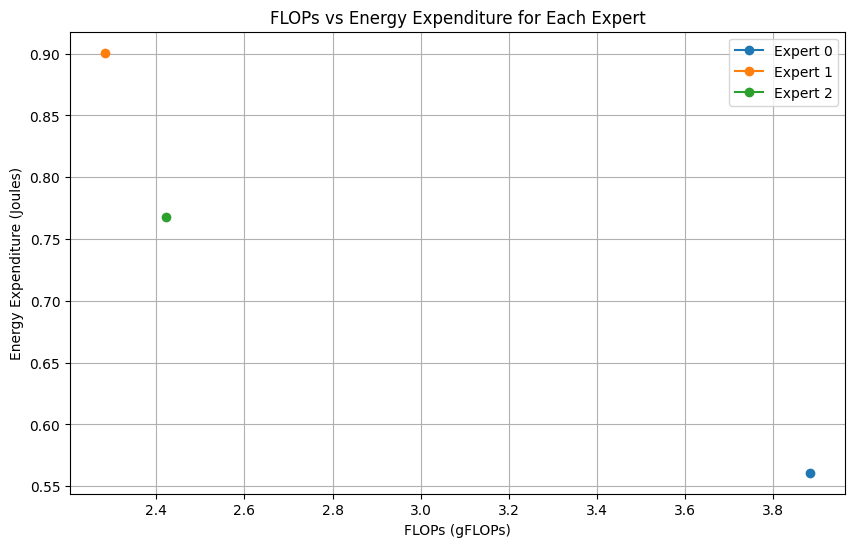

Layer 2 Energy in joules:  15.833970201015472
Layer  2
  Expert 0: 0.6962 J
  Expert 0: 2.8270 gFlops
  Expert 1: 0.6030 J
  Expert 1: 2.4558 gFlops
  Expert 2: 0.6941 J
  Expert 2: 3.3072 gFlops


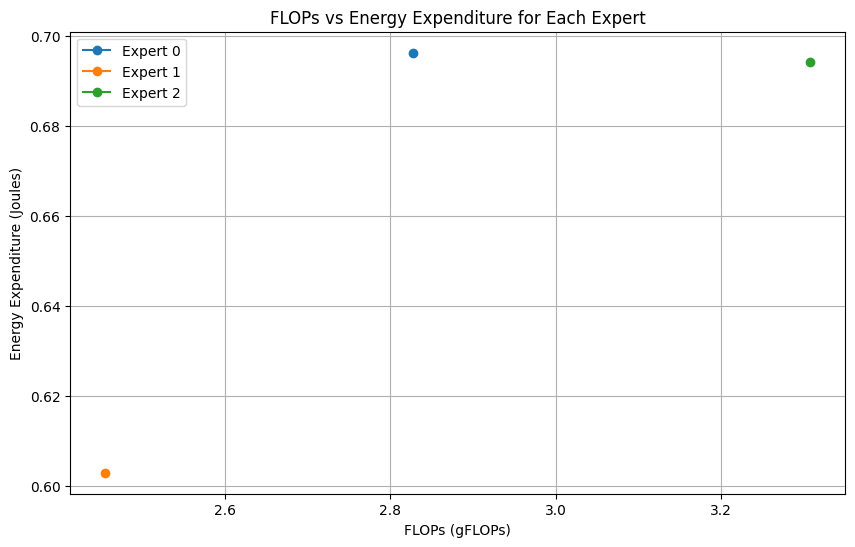

Layer 3 Energy in joules:  12.524675996303559
Layer  3
  Expert 0: 0.5504 J
  Expert 0: 2.2460 gFlops
  Expert 1: 0.6586 J
  Expert 1: 3.8378 gFlops
  Expert 2: 0.7638 J
  Expert 2: 2.5061 gFlops


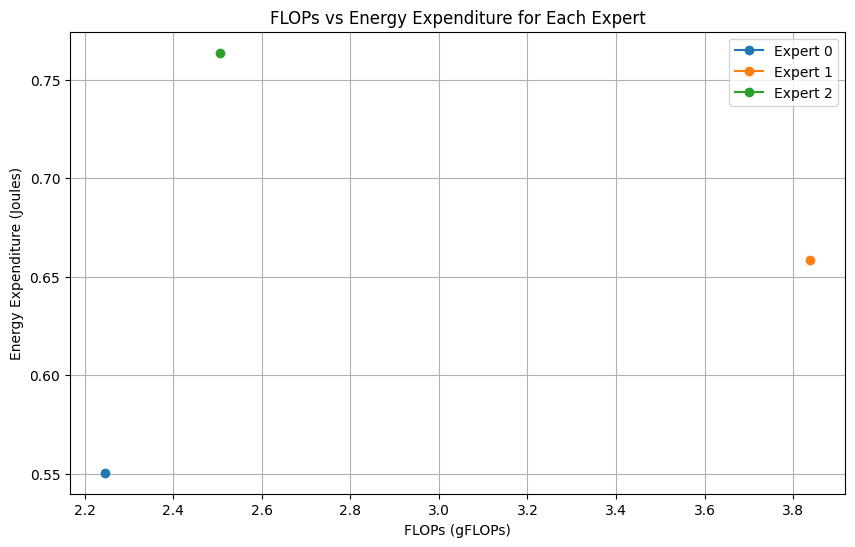

Layer 4 Energy in joules:  29.903917636871338
Layer  4
  Expert 0: 0.5940 J
  Expert 0: 2.6277 gFlops
  Expert 1: 0.7178 J
  Expert 1: 2.9108 gFlops
  Expert 2: 0.6307 J
  Expert 2: 3.0514 gFlops


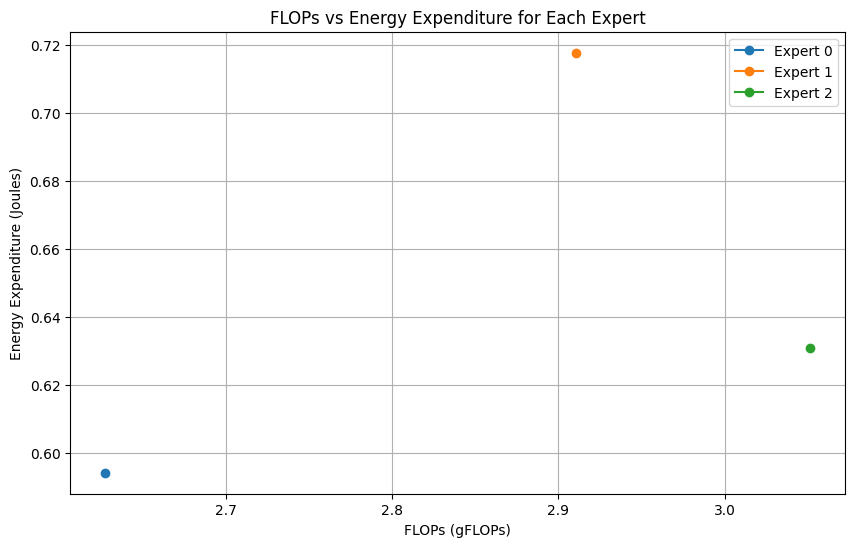

Layer 5 Energy in joules:  12.411610894203188
Layer  5
  Expert 0: 0.6392 J
  Expert 0: 2.6927 gFlops
  Expert 1: 0.6783 J
  Expert 1: 2.8899 gFlops
  Expert 2: 0.6643 J
  Expert 2: 3.0073 gFlops


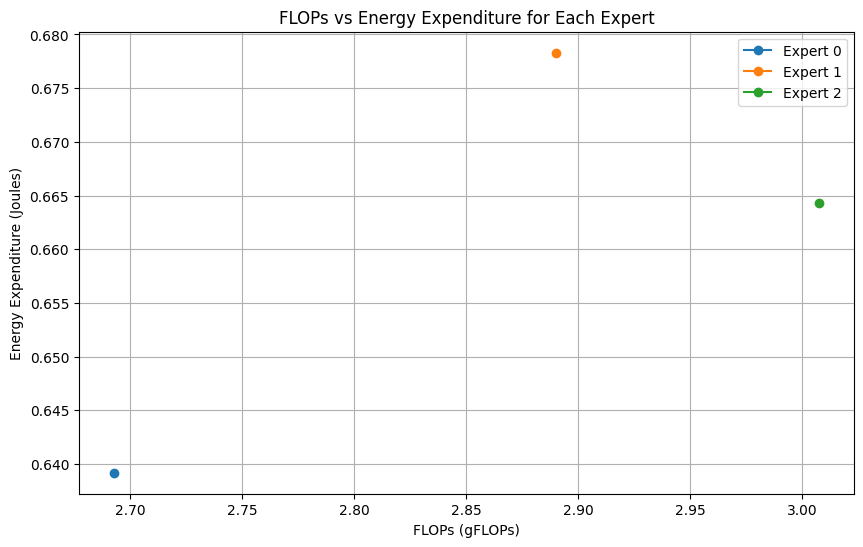

Layer 6 Energy in joules:  13.429696638584138
Layer  6
  Expert 0: 0.6348 J
  Expert 0: 3.4666 gFlops
  Expert 1: 0.6900 J
  Expert 1: 2.0615 gFlops
  Expert 2: 0.7564 J
  Expert 2: 3.0618 gFlops


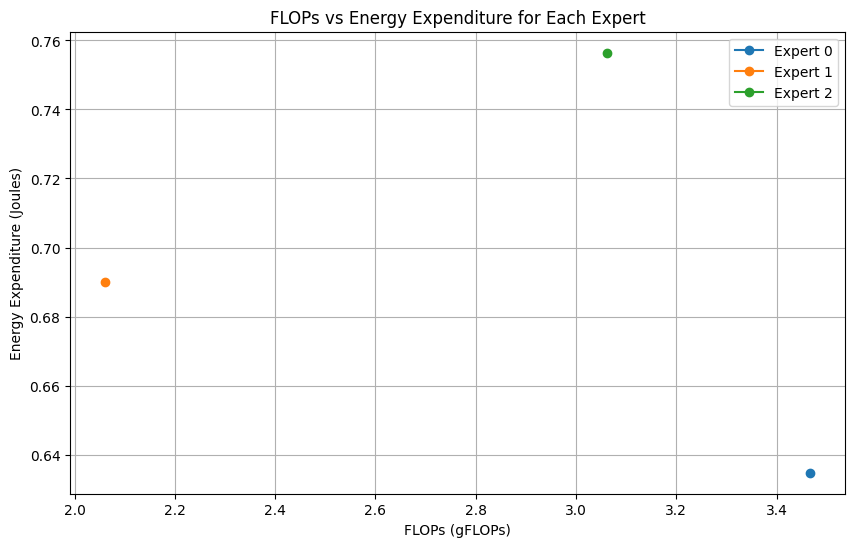

Layer 7 Energy in joules:  13.295701625347139
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.4772 J
  Expert 0: 3.6008 gFlops
  Expert 1: 1.6434 J
  Expert 1: 2.4086 gFlops
  Expert 2: 0.6814 J
  Expert 2: 2.5805 gFlops


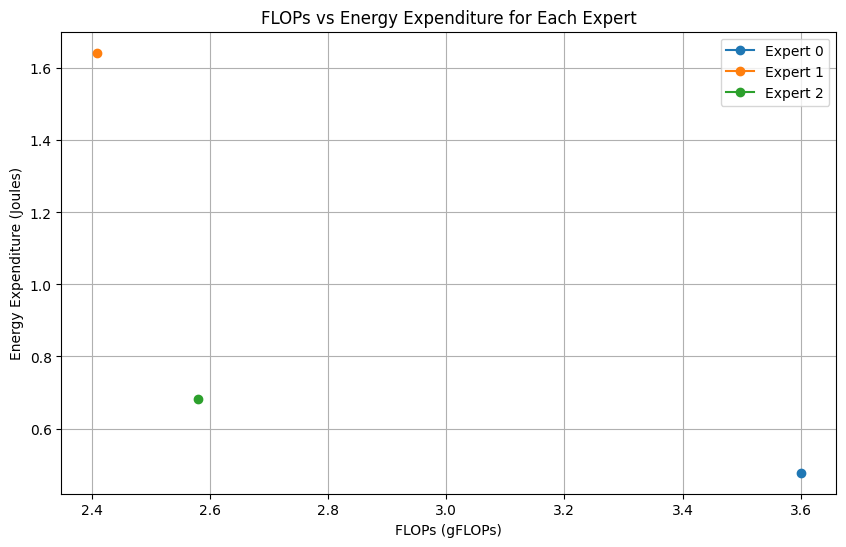

Layer 2 Energy in joules:  24.533982861042023
Layer  2
  Expert 0: 0.4944 J
  Expert 0: 2.8783 gFlops
  Expert 1: 0.4863 J
  Expert 1: 2.6340 gFlops
  Expert 2: 0.5412 J
  Expert 2: 3.0776 gFlops


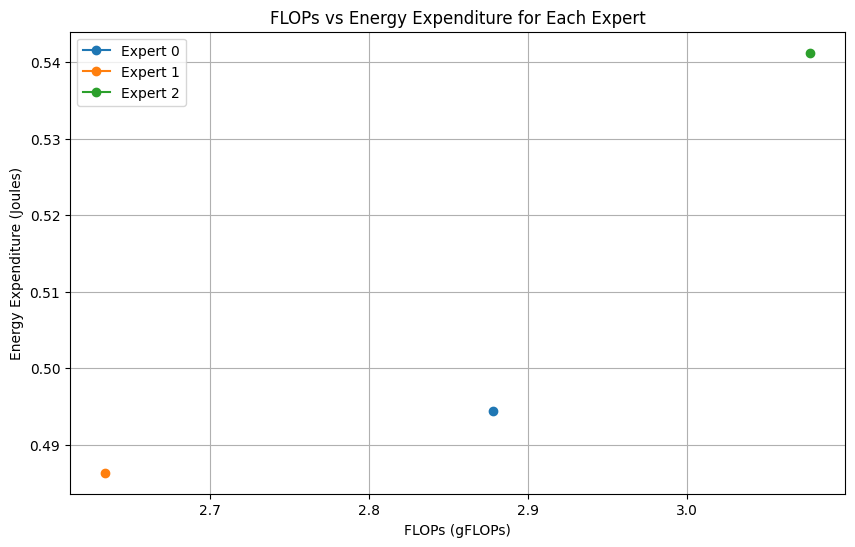

Layer 3 Energy in joules:  23.245917091369627
Layer  3
  Expert 0: 0.5166 J
  Expert 0: 2.2723 gFlops
  Expert 1: 0.6464 J
  Expert 1: 3.6920 gFlops
  Expert 2: 0.5525 J
  Expert 2: 2.6256 gFlops


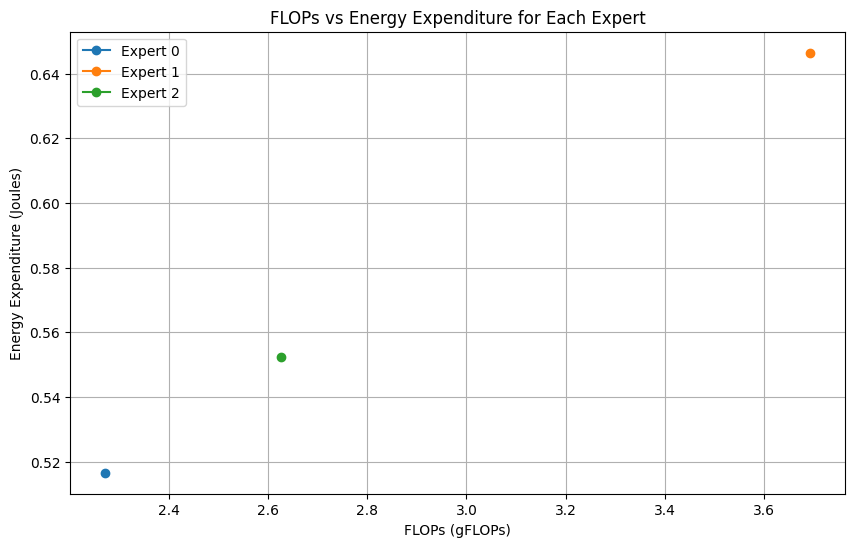

Layer 4 Energy in joules:  25.359493203163147
Layer  4
  Expert 0: 0.6476 J
  Expert 0: 2.6193 gFlops
  Expert 1: 0.4338 J
  Expert 1: 2.9759 gFlops
  Expert 2: 0.4918 J
  Expert 2: 2.9947 gFlops


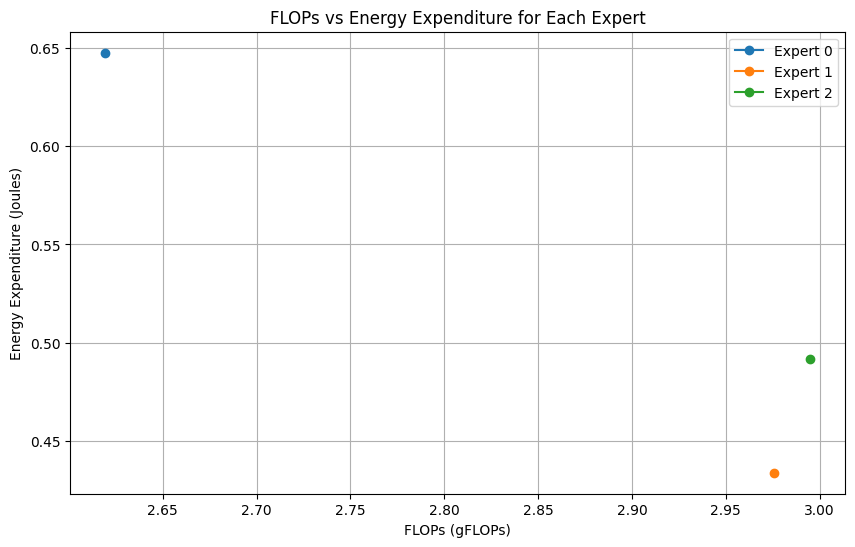

Layer 5 Energy in joules:  18.816905999183657
Layer  5
  Expert 0: 0.4850 J
  Expert 0: 2.5166 gFlops
  Expert 1: 0.4411 J
  Expert 1: 3.0168 gFlops
  Expert 2: 0.3905 J
  Expert 2: 3.0566 gFlops


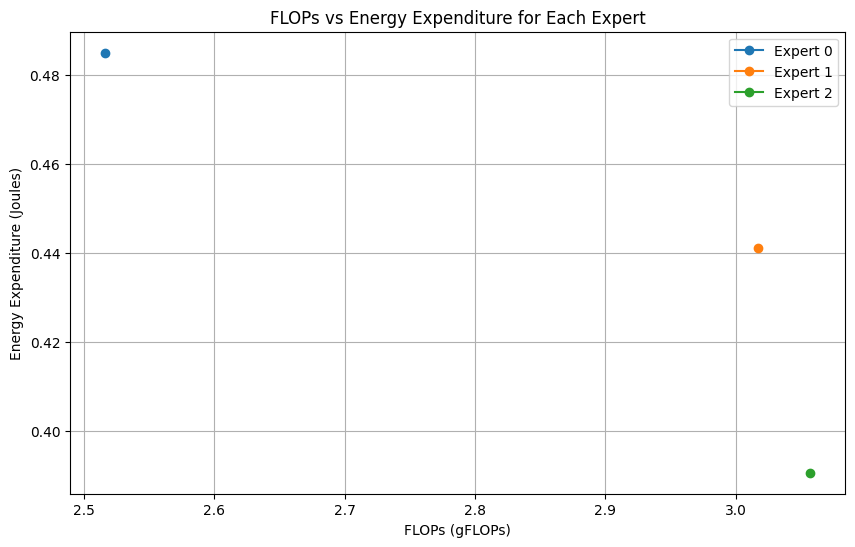

Layer 6 Energy in joules:  19.230524909496307
Layer  6
  Expert 0: 0.4220 J
  Expert 0: 3.2894 gFlops
  Expert 1: 0.4785 J
  Expert 1: 2.3226 gFlops
  Expert 2: 0.3862 J
  Expert 2: 2.9780 gFlops


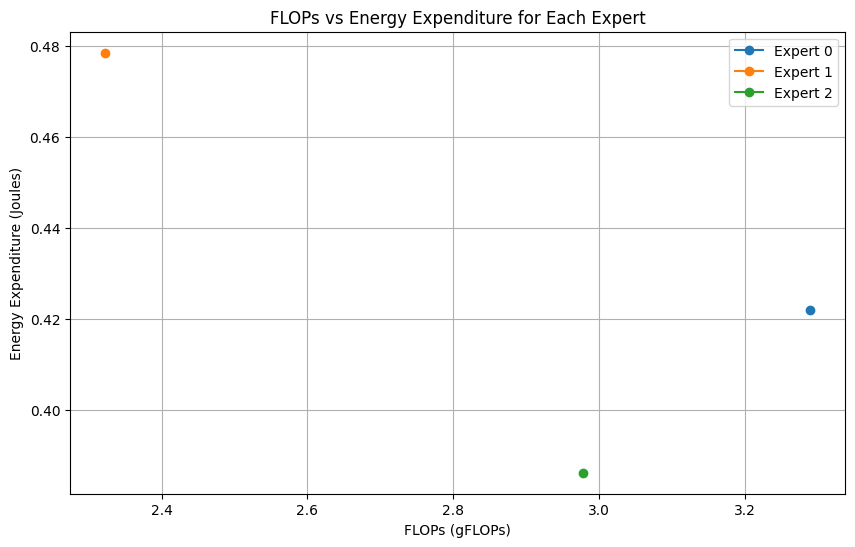

Layer 7 Energy in joules:  14.284004426002502
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.090081990734376
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.090081990734376
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.3001 J
  Expert 0: 3.5505 gFlops
  Expert 1: 0.3287 J
  Expert 1: 2.4572 gFlops
  Expert 2: 0.3106 J
  Expert 2: 2.5823 gFlops


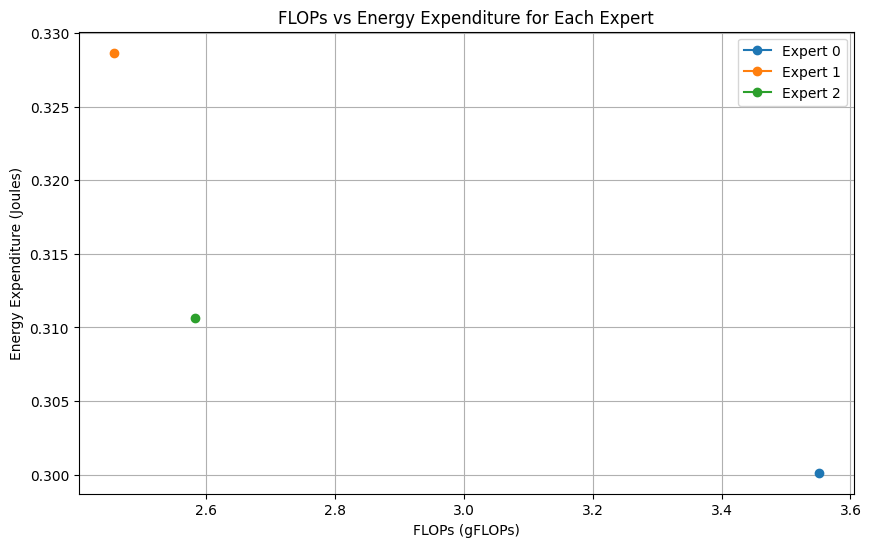

Layer 2 Energy in joules:  17.980880308151246
Layer  2
  Expert 0: 0.3006 J
  Expert 0: 2.8724 gFlops
  Expert 1: 0.3395 J
  Expert 1: 2.6683 gFlops
  Expert 2: 0.3547 J
  Expert 2: 3.0493 gFlops


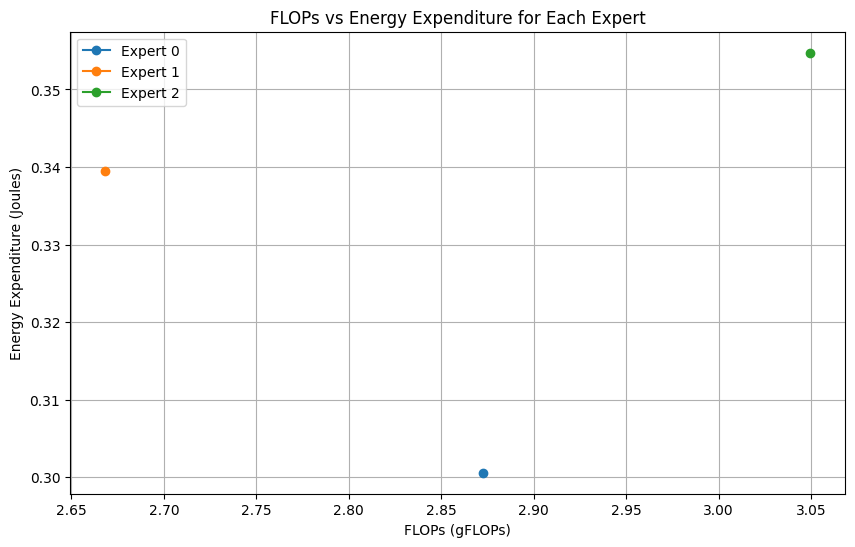

Layer 3 Energy in joules:  18.20760726928711
Layer  3
  Expert 0: 0.2712 J
  Expert 0: 2.3034 gFlops
  Expert 1: 0.3022 J
  Expert 1: 3.6288 gFlops
  Expert 2: 0.3072 J
  Expert 2: 2.6578 gFlops


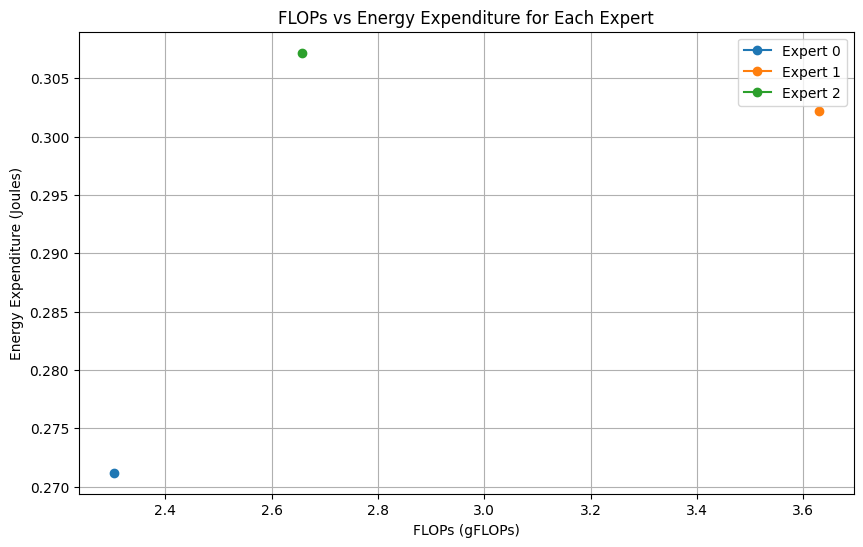

Layer 4 Energy in joules:  18.00535747528076
Layer  4
  Expert 0: 0.2894 J
  Expert 0: 2.5893 gFlops
  Expert 1: 0.3220 J
  Expert 1: 2.9975 gFlops
  Expert 2: 0.3004 J
  Expert 2: 3.0031 gFlops


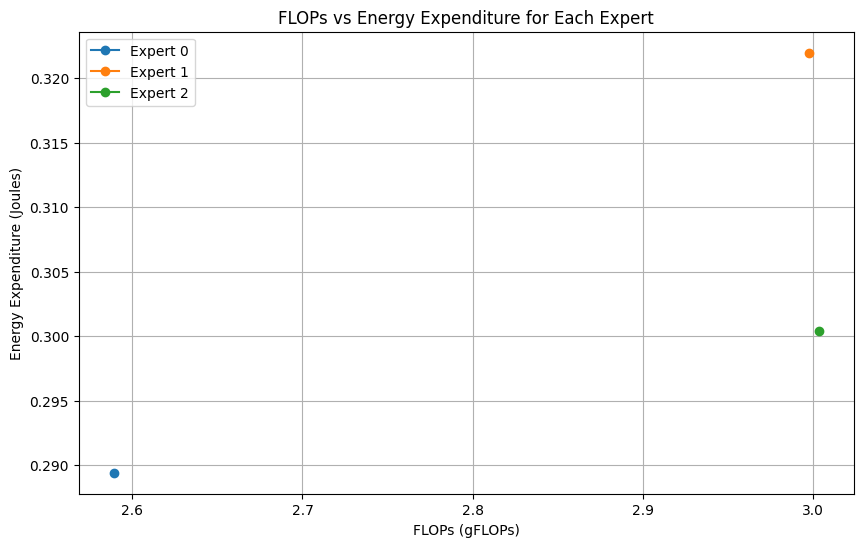

Layer 5 Energy in joules:  17.012525238990783
Layer  5
  Expert 0: 0.2228 J
  Expert 0: 2.3998 gFlops
  Expert 1: 0.2204 J
  Expert 1: 3.0842 gFlops
  Expert 2: 0.2623 J
  Expert 2: 3.1059 gFlops


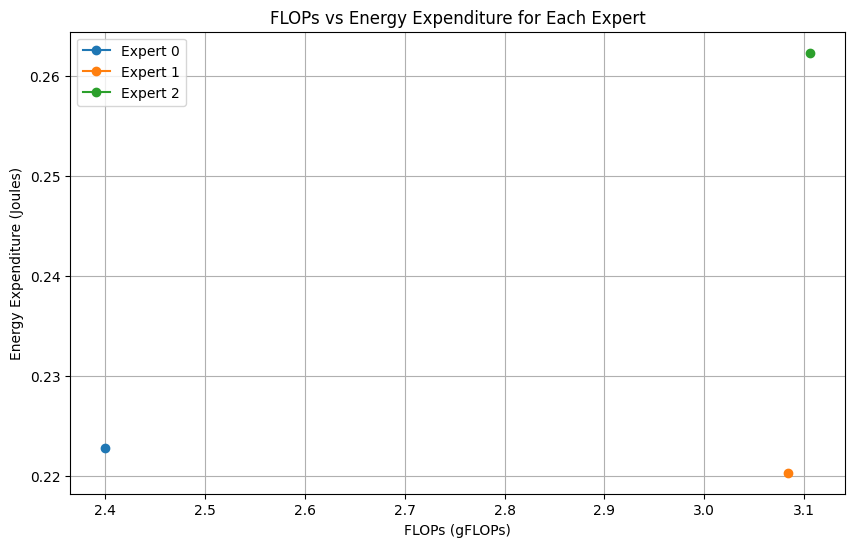

Layer 6 Energy in joules:  12.907809448242187
Layer  6
  Expert 0: 0.2186 J
  Expert 0: 3.2806 gFlops
  Expert 1: 0.2293 J
  Expert 1: 2.3991 gFlops
  Expert 2: 0.2125 J
  Expert 2: 2.9101 gFlops


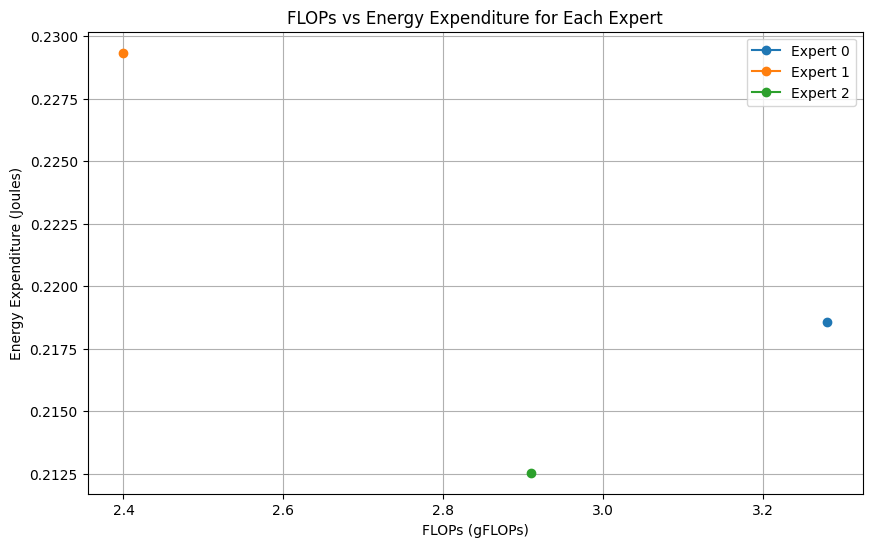

Layer 7 Energy in joules:  12.822608027458191
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.090081990734376
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.2306 J
  Expert 0: 3.5641 gFlops
  Expert 1: 0.6979 J
  Expert 1: 2.4458 gFlops
  Expert 2: 0.2207 J
  Expert 2: 2.5800 gFlops


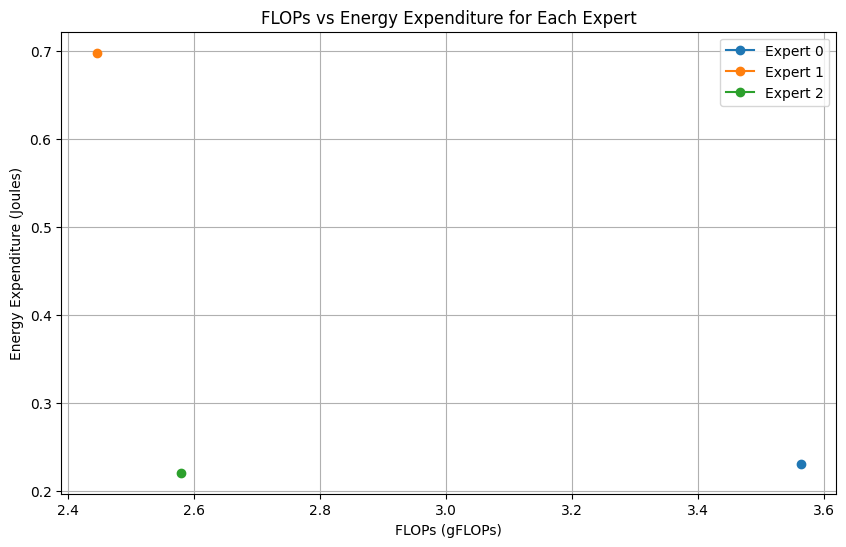

Layer 2 Energy in joules:  20.851976602077485
Layer  2
  Expert 0: 0.2138 J
  Expert 0: 2.8846 gFlops
  Expert 1: 0.2155 J
  Expert 1: 2.5669 gFlops
  Expert 2: 0.2082 J
  Expert 2: 3.1384 gFlops


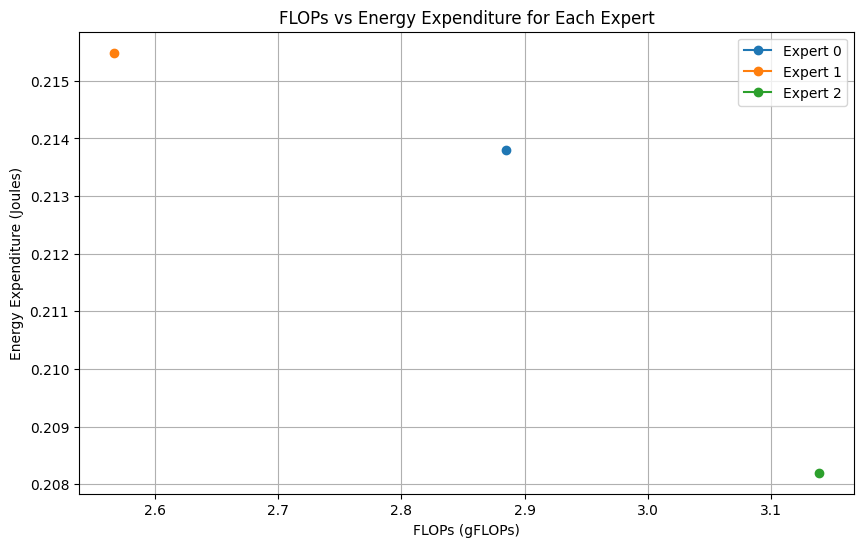

Layer 3 Energy in joules:  17.62811528682709
Layer  3
  Expert 0: 0.2347 J
  Expert 0: 2.3137 gFlops
  Expert 1: 0.2752 J
  Expert 1: 3.6690 gFlops
  Expert 2: 0.2315 J
  Expert 2: 2.6073 gFlops


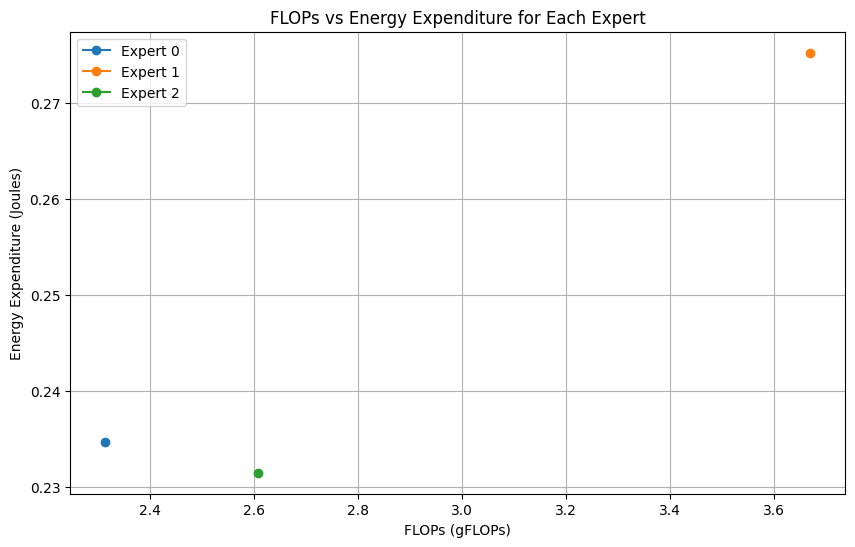

Layer 4 Energy in joules:  16.995124657154083
Layer  4
  Expert 0: 0.2297 J
  Expert 0: 2.5863 gFlops
  Expert 1: 0.2408 J
  Expert 1: 2.8925 gFlops
  Expert 2: 0.3030 J
  Expert 2: 3.1111 gFlops


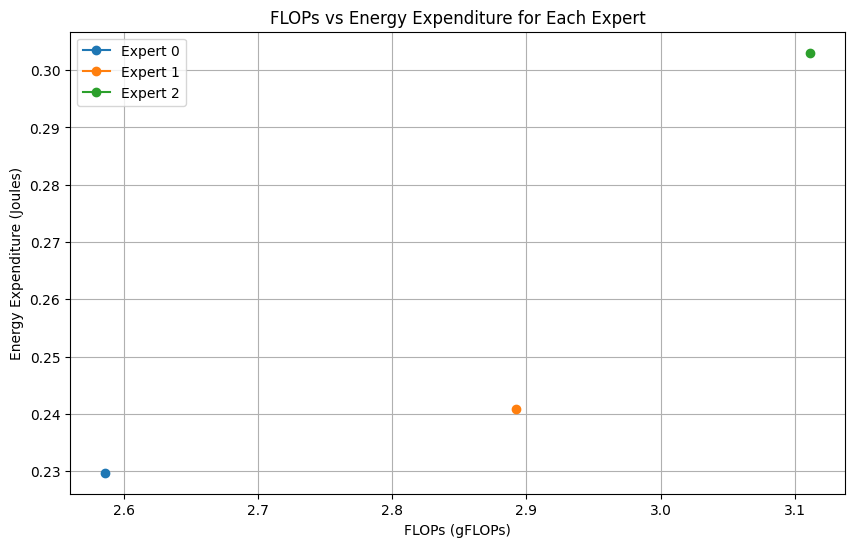

Layer 5 Energy in joules:  17.98141802072525
Layer  5
  Expert 0: 0.2523 J
  Expert 0: 2.3016 gFlops
  Expert 1: 0.2490 J
  Expert 1: 3.1310 gFlops
  Expert 2: 0.2217 J
  Expert 2: 3.1573 gFlops


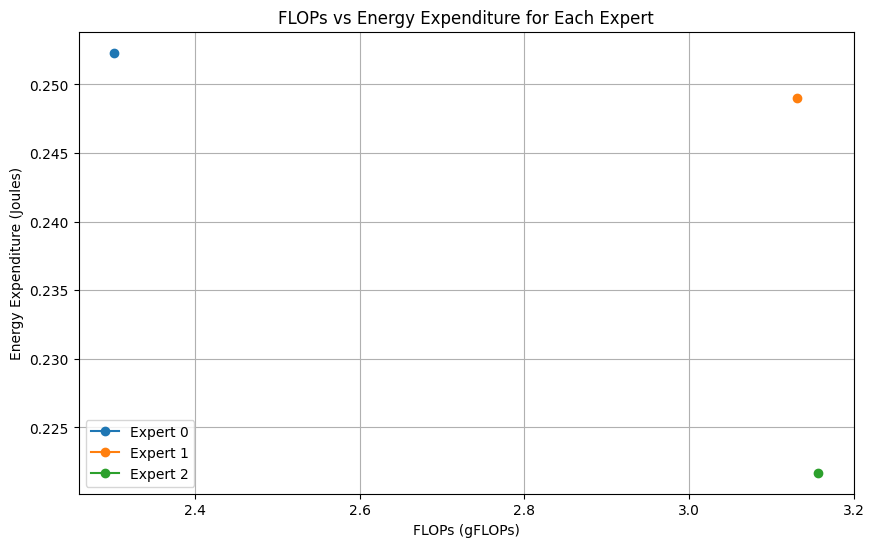

Layer 6 Energy in joules:  12.578042106628416
Layer  6
  Expert 0: 0.1687 J
  Expert 0: 3.3512 gFlops
  Expert 1: 0.1751 J
  Expert 1: 2.4264 gFlops
  Expert 2: 0.1826 J
  Expert 2: 2.8123 gFlops


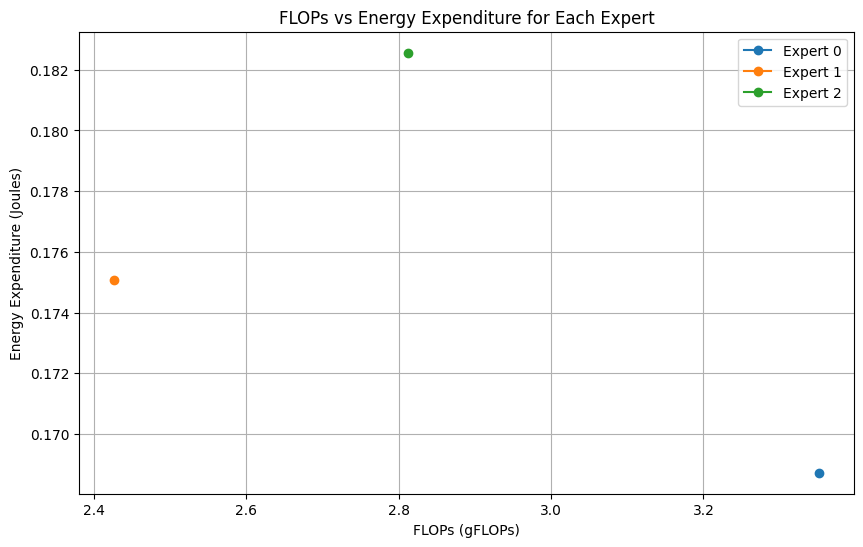

Layer 7 Energy in joules:  13.288585510253904
Layer 1 Gflops: 12.090081990734376
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.090081990734376
Layer 4 Gflops: 12.090081990734376
Layer 5 Gflops: 12.090081990734376
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.1786 J
  Expert 0: 3.5257 gFlops
  Expert 1: 0.1880 J
  Expert 1: 2.4751 gFlops
  Expert 2: 0.1520 J
  Expert 2: 2.5891 gFlops


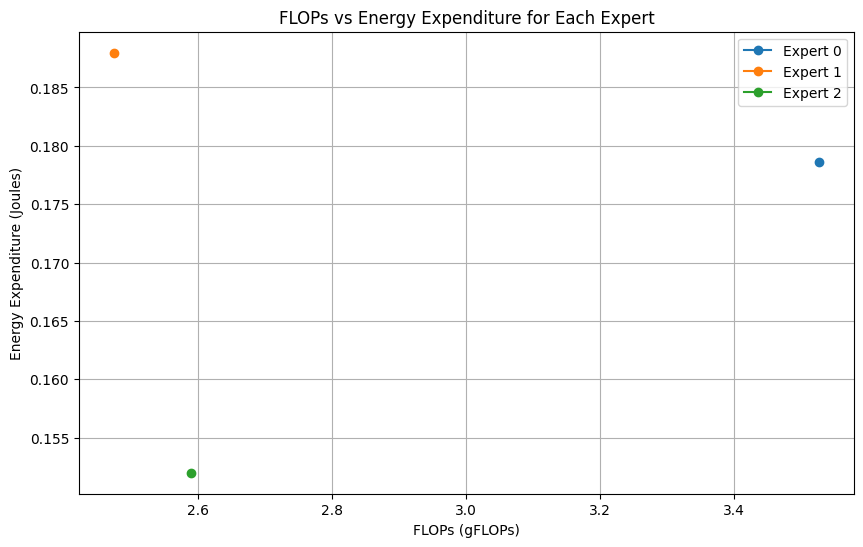

Layer 2 Energy in joules:  18.309812545776367
Layer  2
  Expert 0: 0.1491 J
  Expert 0: 2.9075 gFlops
  Expert 1: 0.1668 J
  Expert 1: 2.5132 gFlops
  Expert 2: 0.2540 J
  Expert 2: 3.1692 gFlops


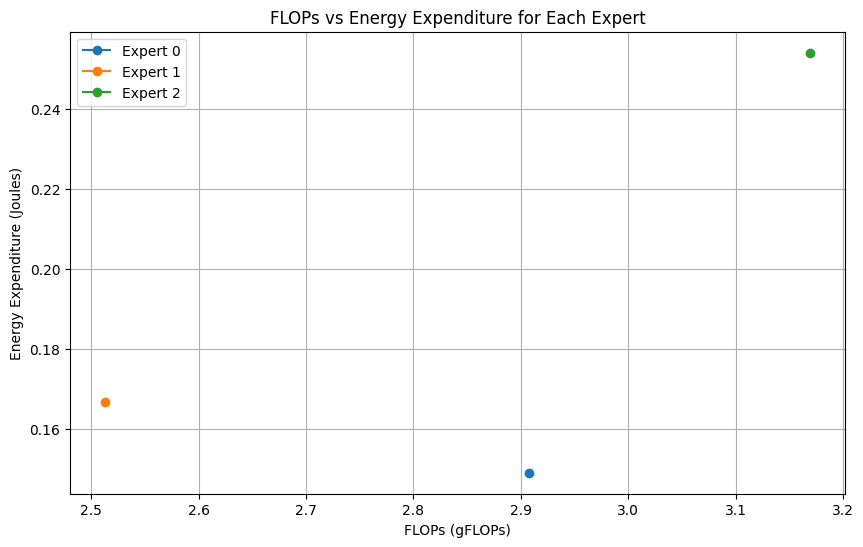

Layer 3 Energy in joules:  21.28123373746872
Layer  3
  Expert 0: 0.1779 J
  Expert 0: 2.3685 gFlops
  Expert 1: 0.1739 J
  Expert 1: 3.5912 gFlops
  Expert 2: 0.1796 J
  Expert 2: 2.6302 gFlops


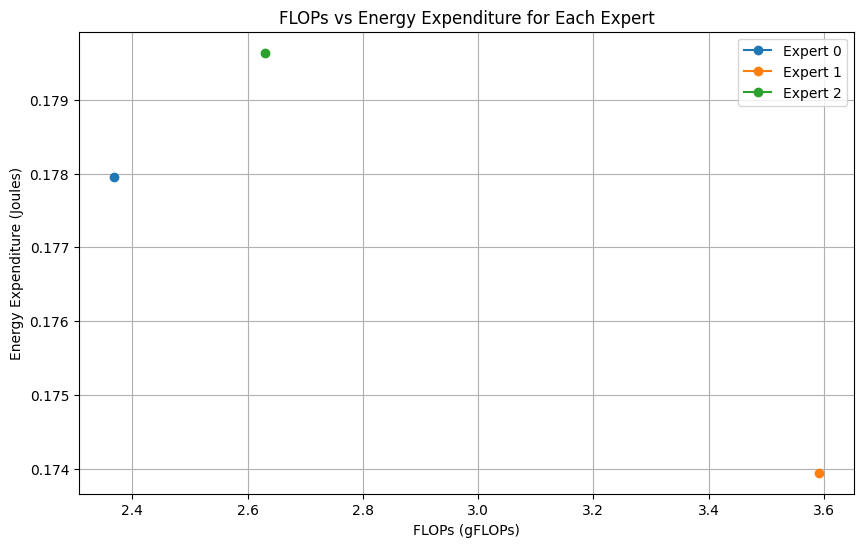

Layer 4 Energy in joules:  22.869521689414977
Layer  4
  Expert 0: 0.2268 J
  Expert 0: 2.6168 gFlops
  Expert 1: 0.2094 J
  Expert 1: 2.8161 gFlops
  Expert 2: 0.1971 J
  Expert 2: 3.1571 gFlops


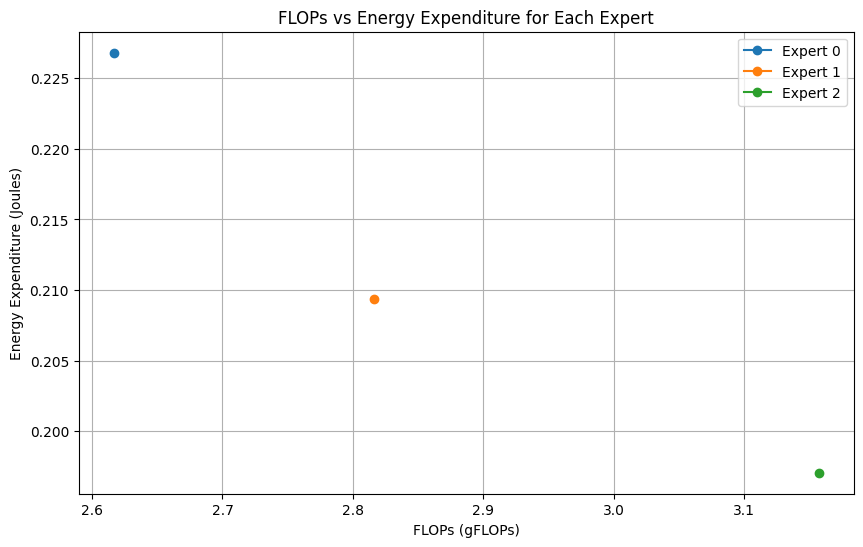

Layer 5 Energy in joules:  17.812596015930175
Layer  5
  Expert 0: 0.1718 J
  Expert 0: 2.3098 gFlops
  Expert 1: 0.2151 J
  Expert 1: 3.1873 gFlops
  Expert 2: 0.1932 J
  Expert 2: 3.0929 gFlops


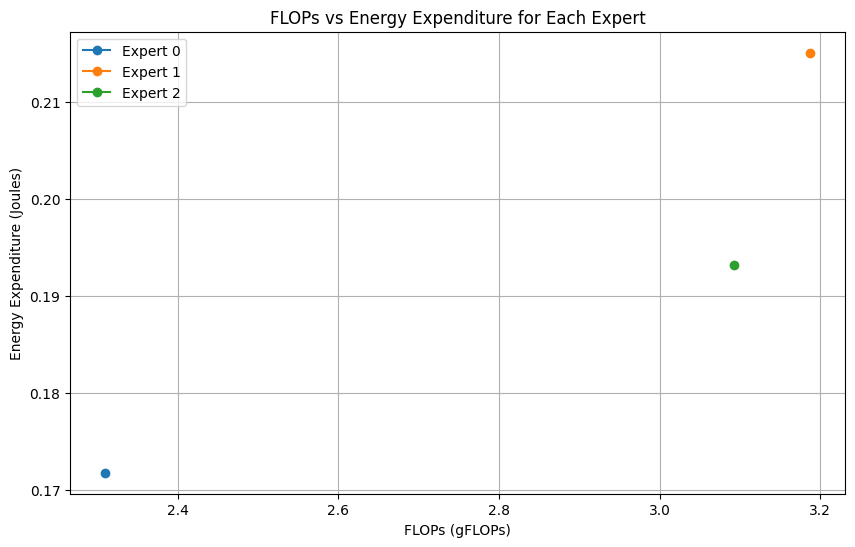

Layer 6 Energy in joules:  19.17616642951965
Layer  6
  Expert 0: 0.1670 J
  Expert 0: 3.2401 gFlops
  Expert 1: 0.1528 J
  Expert 1: 2.5782 gFlops
  Expert 2: 0.1549 J
  Expert 2: 2.7716 gFlops


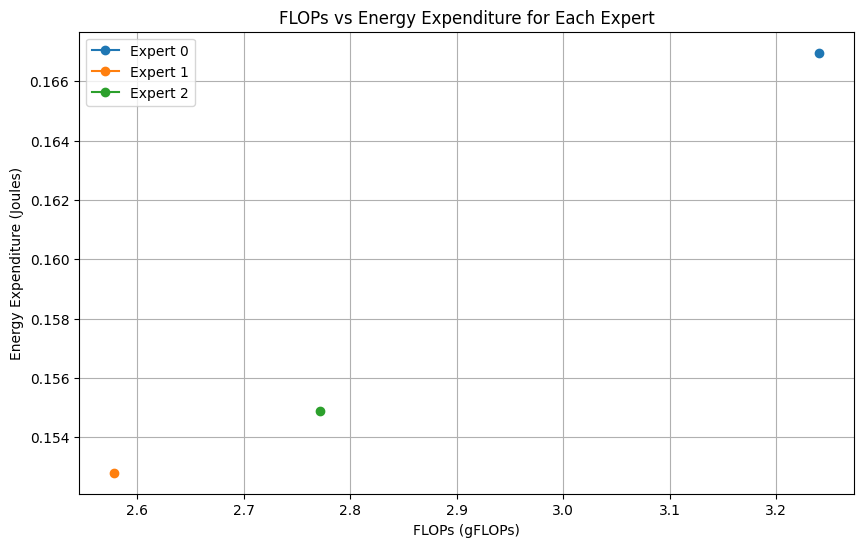

Layer 7 Energy in joules:  18.416307563781736
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.090081990734376
Layer 5 Gflops: 12.090081990734376
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.1533 J
  Expert 0: 3.4946 gFlops
  Expert 1: 0.1483 J
  Expert 1: 2.4844 gFlops
  Expert 2: 0.1592 J
  Expert 2: 2.6110 gFlops


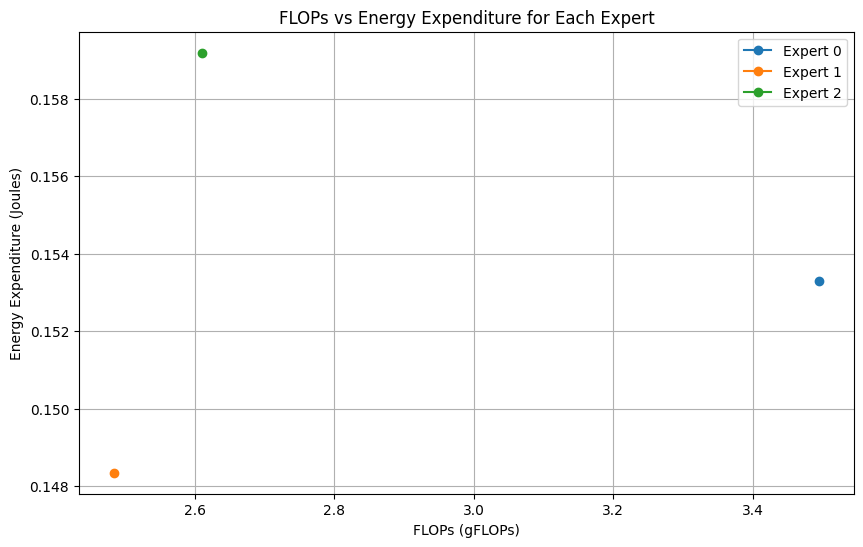

Layer 2 Energy in joules:  16.239795684814453
Layer  2
  Expert 0: 0.1397 J
  Expert 0: 2.9423 gFlops
  Expert 1: 0.1684 J
  Expert 1: 2.4907 gFlops
  Expert 2: 0.1746 J
  Expert 2: 3.1569 gFlops


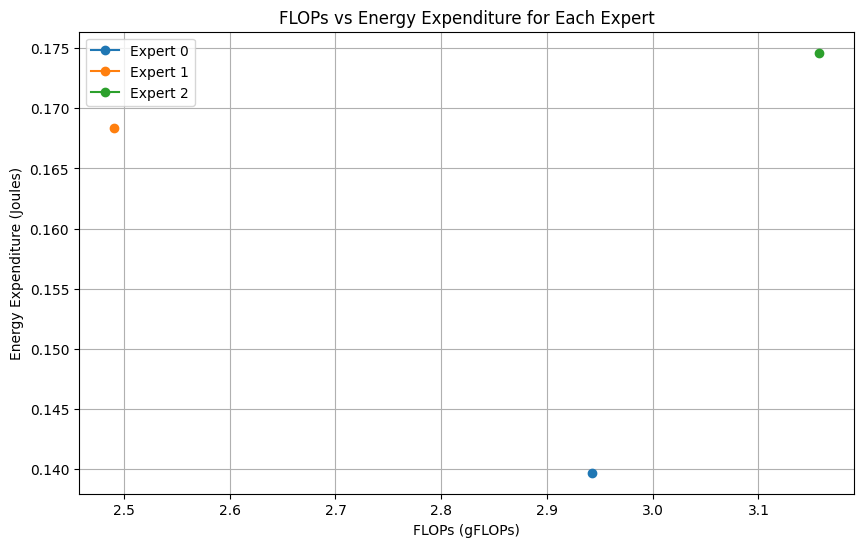

Layer 3 Energy in joules:  17.085418701171875
Layer  3
  Expert 0: 0.1384 J
  Expert 0: 2.4156 gFlops
  Expert 1: 0.1238 J
  Expert 1: 3.5026 gFlops
  Expert 2: 0.1421 J
  Expert 2: 2.6718 gFlops


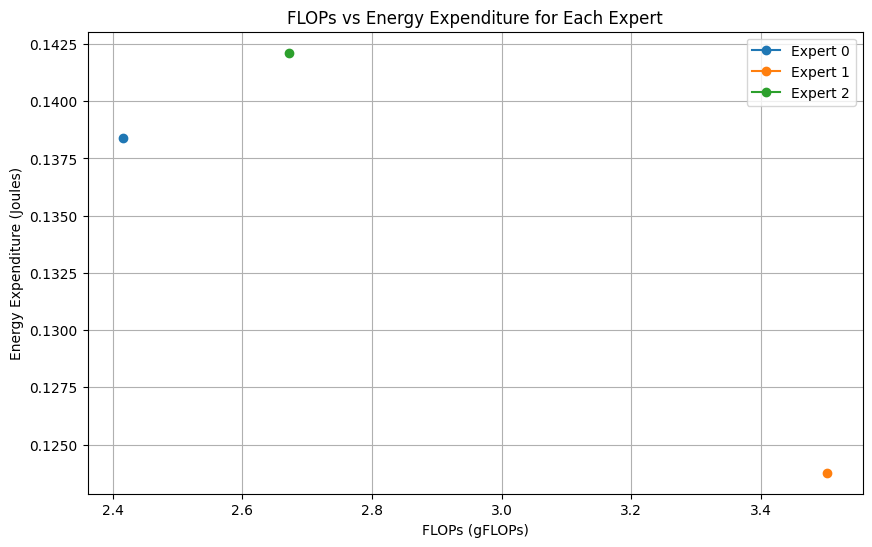

Layer 4 Energy in joules:  16.673927974700927
Layer  4
  Expert 0: 0.1289 J
  Expert 0: 2.6700 gFlops
  Expert 1: 0.1329 J
  Expert 1: 2.7798 gFlops
  Expert 2: 0.1356 J
  Expert 2: 3.1401 gFlops


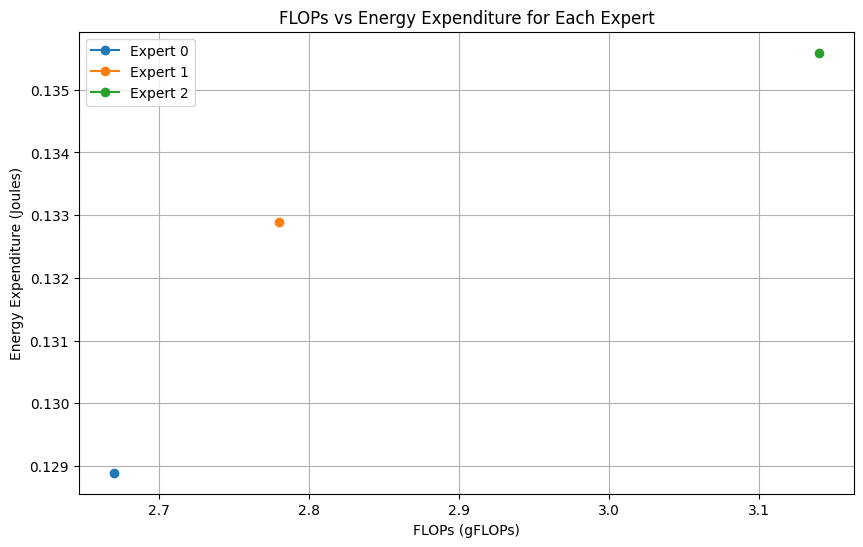

Layer 5 Energy in joules:  16.66224493980408
Layer  5
  Expert 0: 0.1110 J
  Expert 0: 2.3257 gFlops
  Expert 1: 0.1087 J
  Expert 1: 3.2223 gFlops
  Expert 2: 0.1122 J
  Expert 2: 3.0419 gFlops


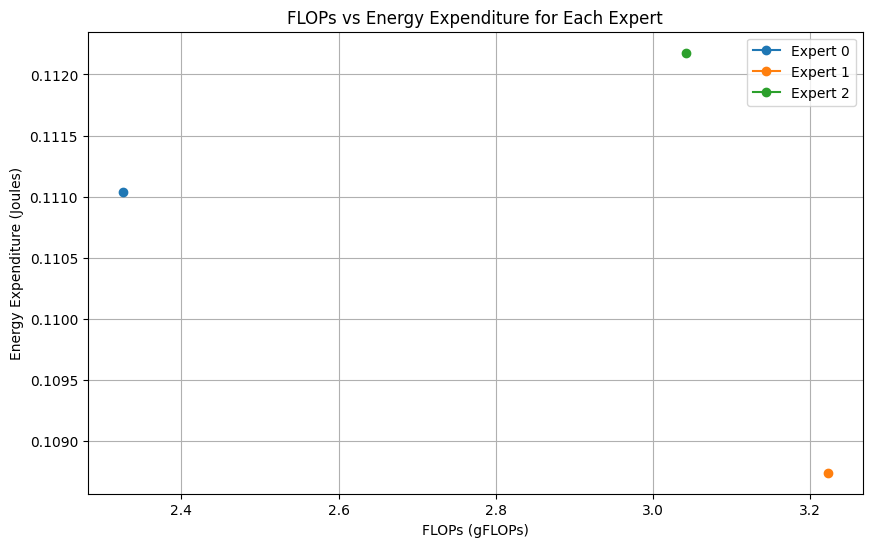

Layer 6 Energy in joules:  13.240993080139159
Layer  6
  Expert 0: 0.1121 J
  Expert 0: 3.1241 gFlops
  Expert 1: 0.1146 J
  Expert 1: 2.7469 gFlops
  Expert 2: 0.1120 J
  Expert 2: 2.7190 gFlops


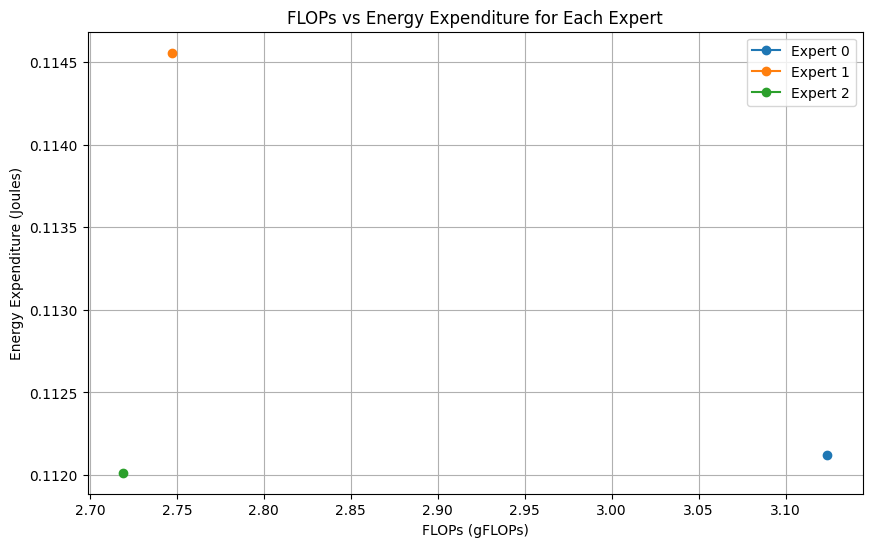

Layer 7 Energy in joules:  13.51081386566162
Layer 1 Gflops: 12.090081990734376
Layer 2 Gflops: 12.090081990734376
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.090081990734376
torch.Size([16, 256, 32000])
Epoch 1/2, Loss: 9.677473862965902
Layer  1
  Expert 0: 0.4094 J
  Expert 0: 3.4867 gFlops
  Expert 1: 0.1366 J
  Expert 1: 2.5037 gFlops
  Expert 2: 0.1573 J
  Expert 2: 2.5996 gFlops


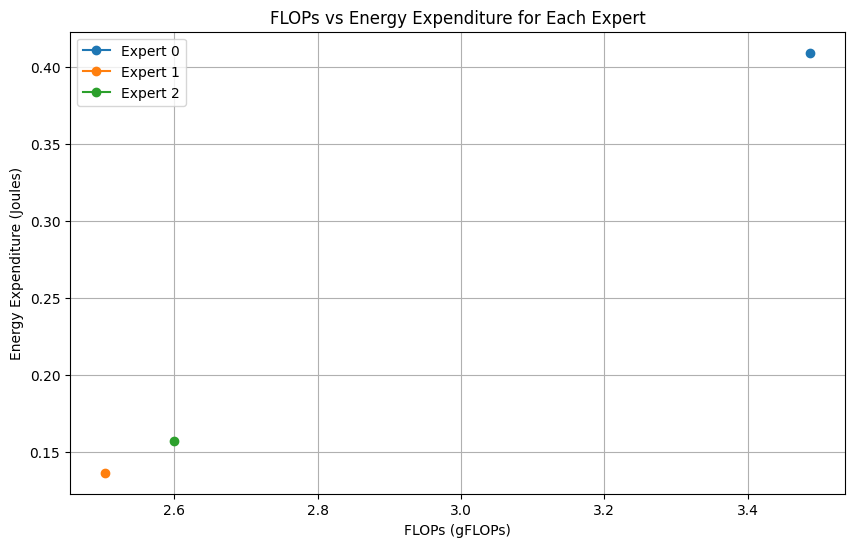

Layer 2 Energy in joules:  18.817361090183258
Layer  2
  Expert 0: 0.1229 J
  Expert 0: 2.9651 gFlops
  Expert 1: 0.1453 J
  Expert 1: 2.4680 gFlops
  Expert 2: 0.1290 J
  Expert 2: 3.1568 gFlops


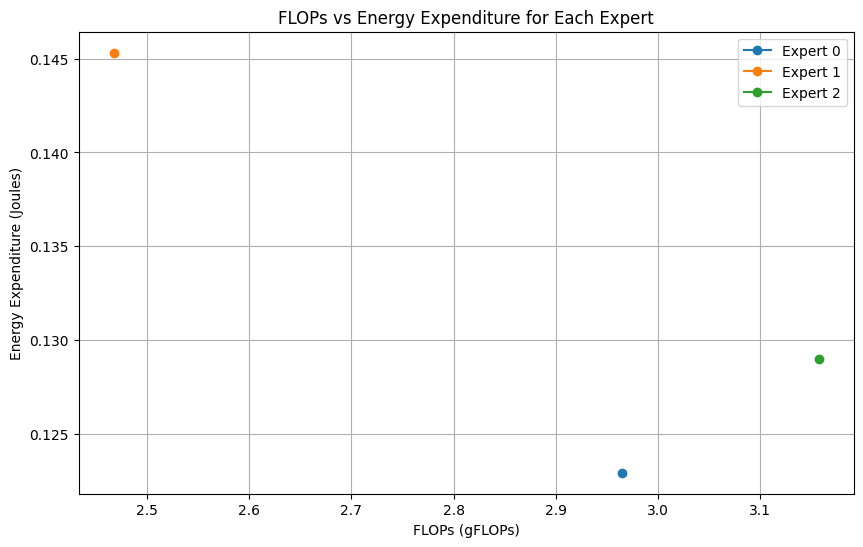

Layer 3 Energy in joules:  16.846146459579465
Layer  3
  Expert 0: 0.1174 J
  Expert 0: 2.4546 gFlops
  Expert 1: 0.1380 J
  Expert 1: 3.4507 gFlops
  Expert 2: 0.1422 J
  Expert 2: 2.6847 gFlops


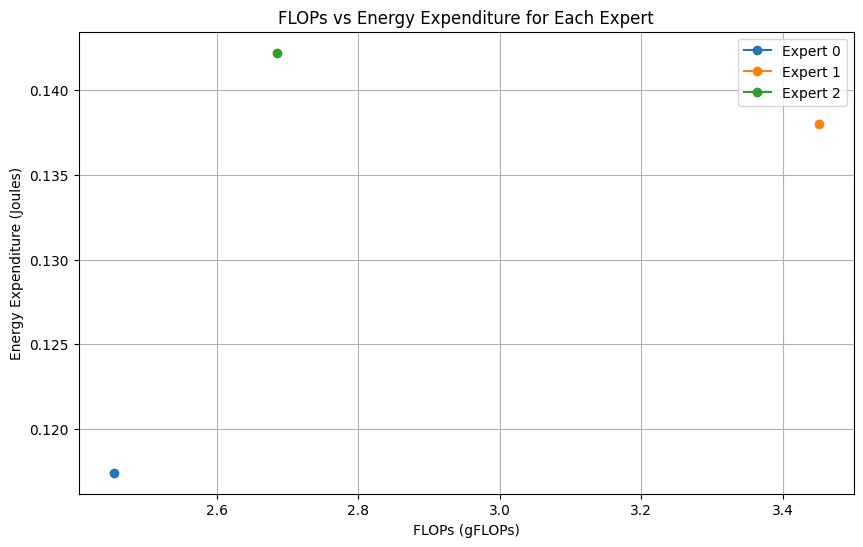

Layer 4 Energy in joules:  16.20184904575348
Layer  4
  Expert 0: 0.1127 J
  Expert 0: 2.7152 gFlops
  Expert 1: 0.1065 J
  Expert 1: 2.7362 gFlops
  Expert 2: 0.1182 J
  Expert 2: 3.1385 gFlops


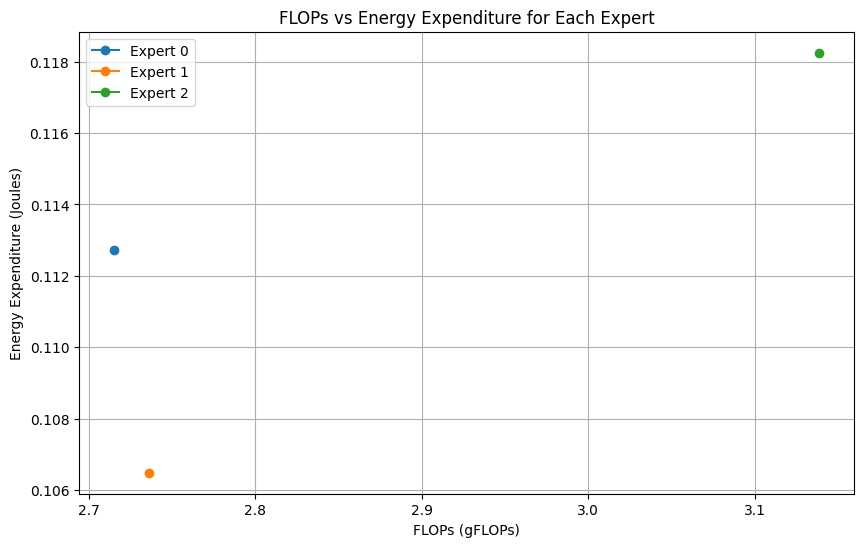

Layer 5 Energy in joules:  16.38528675556183
Layer  5
  Expert 0: 0.1014 J
  Expert 0: 2.3281 gFlops
  Expert 1: 0.0973 J
  Expert 1: 3.2365 gFlops
  Expert 2: 0.0873 J
  Expert 2: 3.0253 gFlops


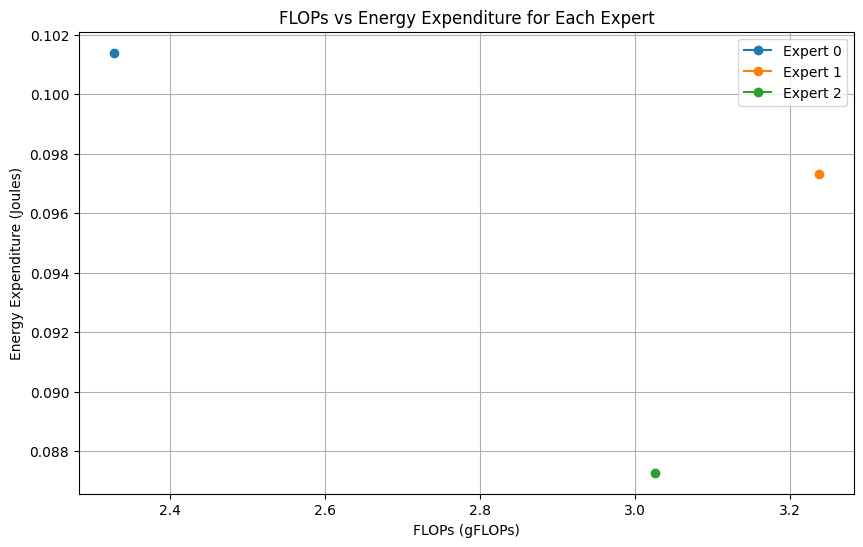

Layer 6 Energy in joules:  13.550370712280271
Layer  6
  Expert 0: 0.0834 J
  Expert 0: 3.0621 gFlops
  Expert 1: 0.0842 J
  Expert 1: 2.8893 gFlops
  Expert 2: 0.0836 J
  Expert 2: 2.6385 gFlops


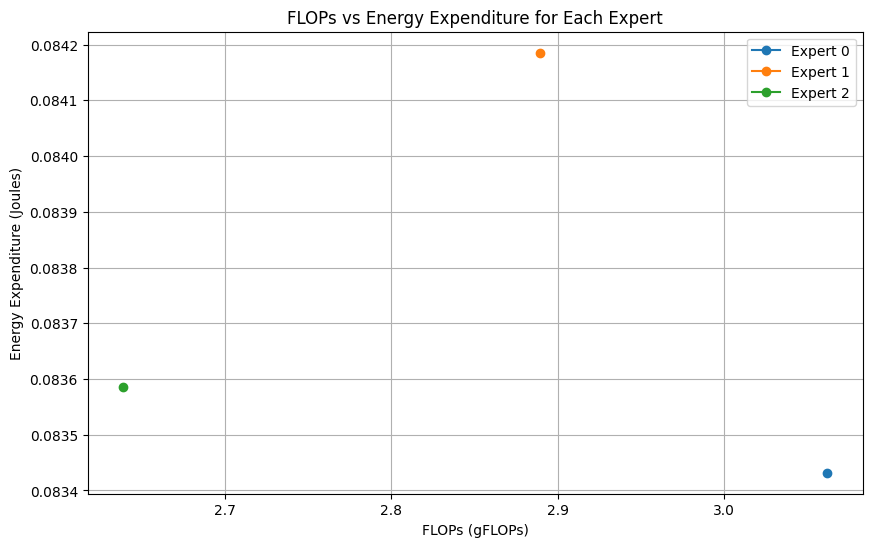

Layer 7 Energy in joules:  13.271624908447265
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.090081990734376
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.1018 J
  Expert 0: 3.4511 gFlops
  Expert 1: 0.3819 J
  Expert 1: 2.5247 gFlops
  Expert 2: 0.1310 J
  Expert 2: 2.6141 gFlops


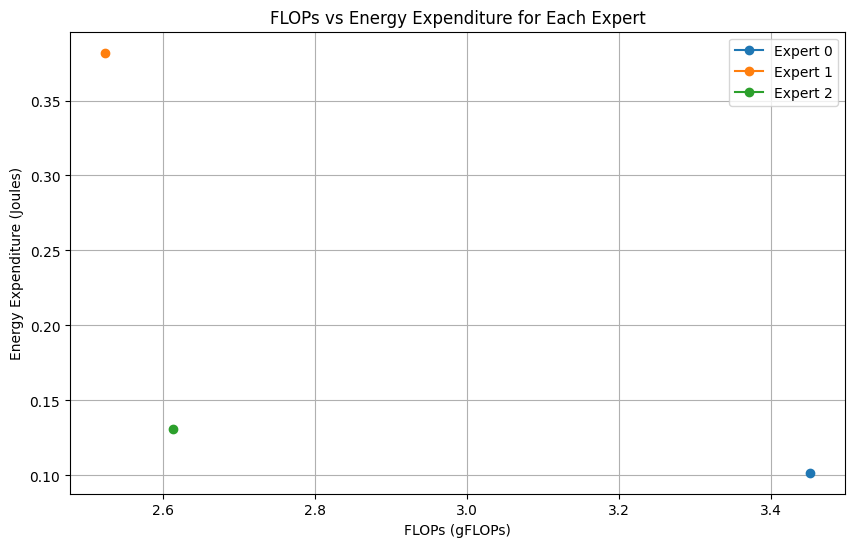

Layer 2 Energy in joules:  20.212623920440674
Layer  2
  Expert 0: 0.1369 J
  Expert 0: 2.9842 gFlops
  Expert 1: 0.1354 J
  Expert 1: 2.4799 gFlops
  Expert 2: 0.1213 J
  Expert 2: 3.1258 gFlops


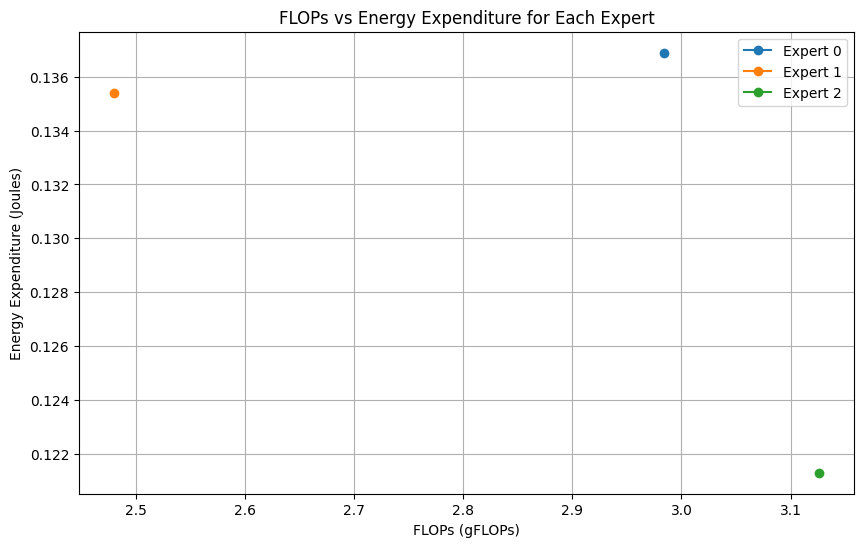

Layer 3 Energy in joules:  18.086489551067352
Layer  3
  Expert 0: 0.0993 J
  Expert 0: 2.5161 gFlops
  Expert 1: 0.1617 J
  Expert 1: 3.3693 gFlops
  Expert 2: 0.1651 J
  Expert 2: 2.7045 gFlops


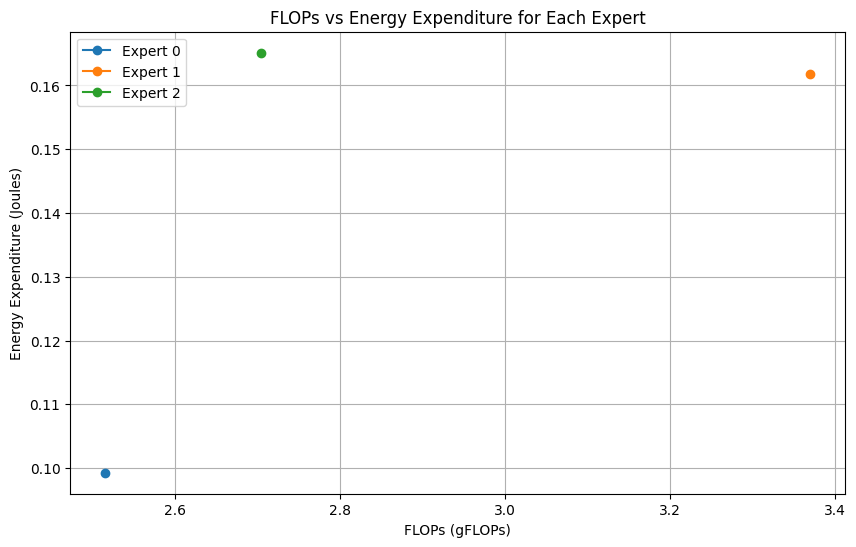

Layer 4 Energy in joules:  17.782337951660157
Layer  4
  Expert 0: 0.1090 J
  Expert 0: 2.7656 gFlops
  Expert 1: 0.1211 J
  Expert 1: 2.7315 gFlops
  Expert 2: 0.1547 J
  Expert 2: 3.0928 gFlops


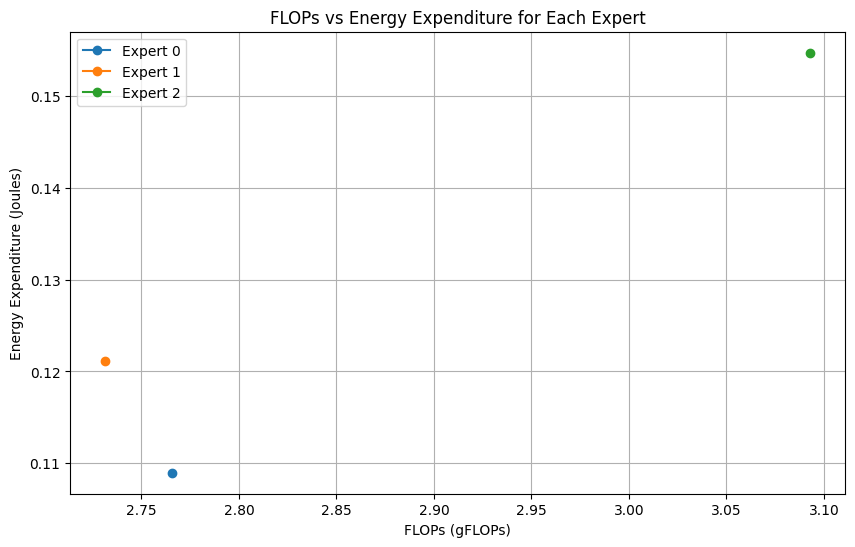

Layer 5 Energy in joules:  22.9170529460907
Layer  5
  Expert 0: 0.1129 J
  Expert 0: 2.3538 gFlops
  Expert 1: 0.1021 J
  Expert 1: 3.2671 gFlops
  Expert 2: 0.1011 J
  Expert 2: 2.9690 gFlops


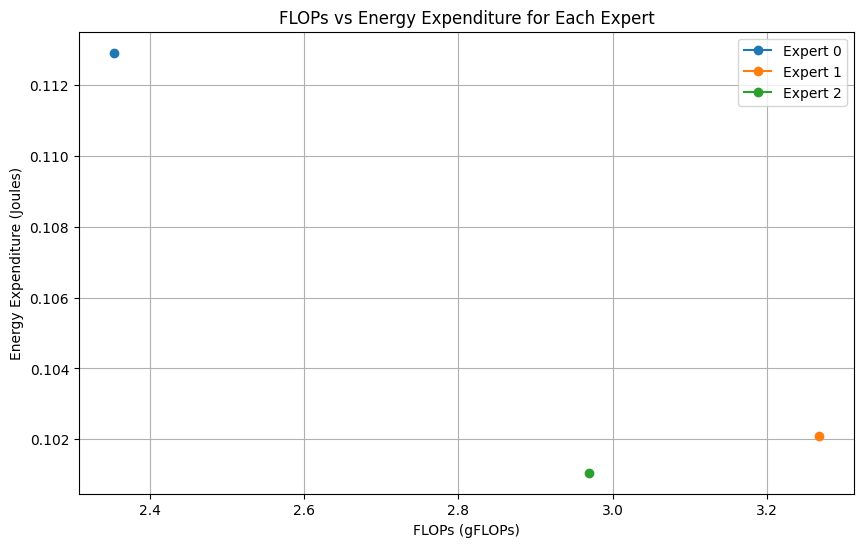

Layer 6 Energy in joules:  18.413878326416015
Layer  6
  Expert 0: 0.0956 J
  Expert 0: 2.9727 gFlops
  Expert 1: 0.0917 J
  Expert 1: 3.0139 gFlops
  Expert 2: 0.1055 J
  Expert 2: 2.6034 gFlops


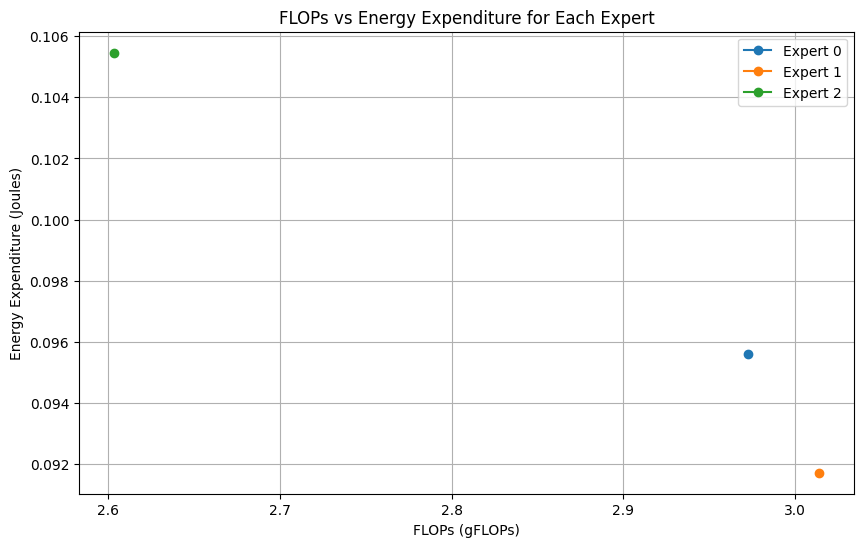

Layer 7 Energy in joules:  18.447813491821286
Layer 1 Gflops: 12.090081990734376
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.090081990734376
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.4280 J
  Expert 0: 3.3962 gFlops
  Expert 1: 0.1464 J
  Expert 1: 2.5508 gFlops
  Expert 2: 0.1384 J
  Expert 2: 2.6429 gFlops


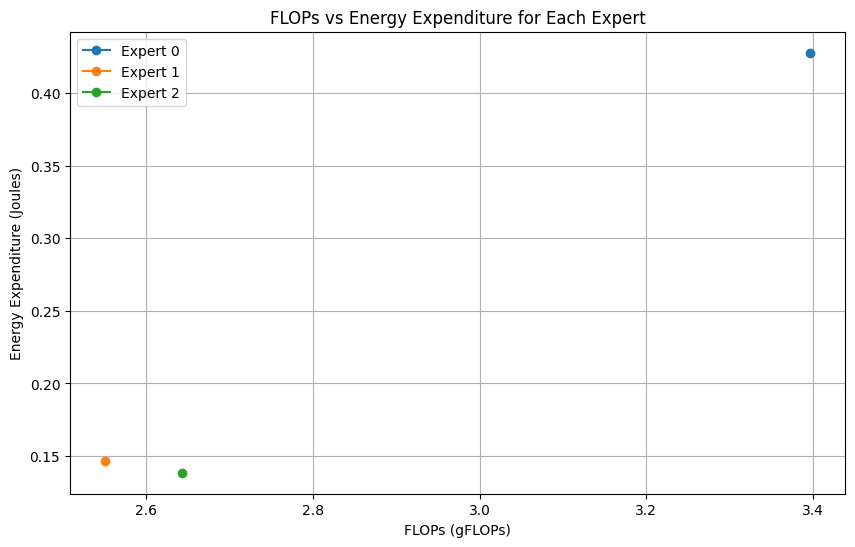

Layer 2 Energy in joules:  24.368447265625
Layer  2
  Expert 0: 0.1035 J
  Expert 0: 3.0094 gFlops
  Expert 1: 0.1020 J
  Expert 1: 2.4977 gFlops
  Expert 2: 0.0984 J
  Expert 2: 3.0828 gFlops


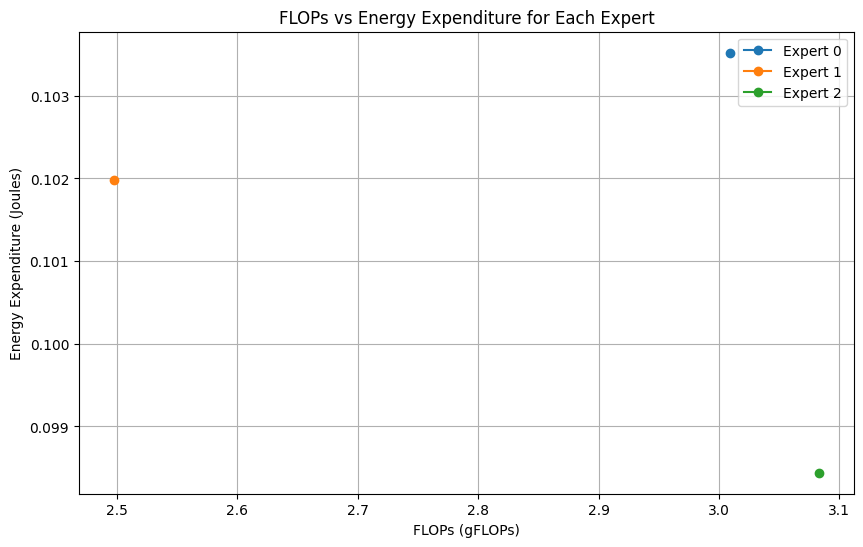

Layer 3 Energy in joules:  20.76239769935608
Layer  3
  Expert 0: 0.0813 J
  Expert 0: 2.5711 gFlops
  Expert 1: 0.1071 J
  Expert 1: 3.2716 gFlops
  Expert 2: 0.1094 J
  Expert 2: 2.7473 gFlops


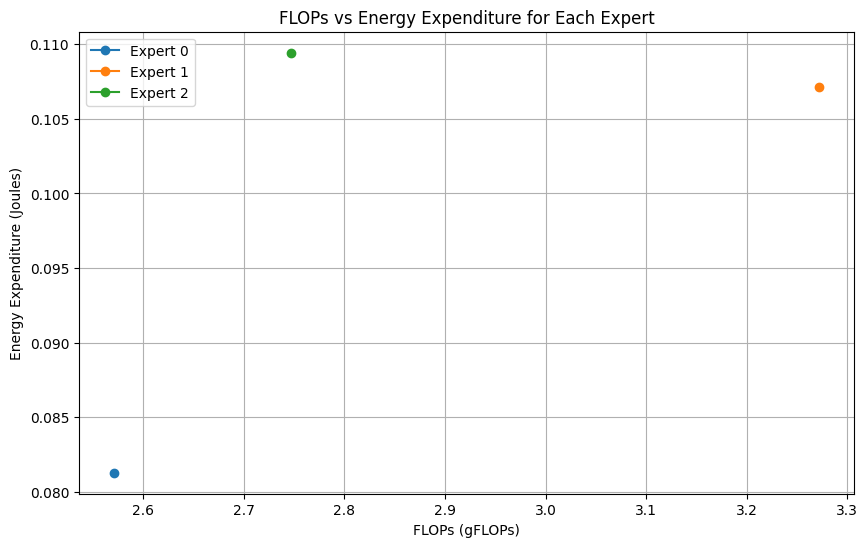

Layer 4 Energy in joules:  17.222060546875
Layer  4
  Expert 0: 0.1067 J
  Expert 0: 2.8046 gFlops
  Expert 1: 0.0915 J
  Expert 1: 2.7487 gFlops
  Expert 2: 0.1035 J
  Expert 2: 3.0367 gFlops


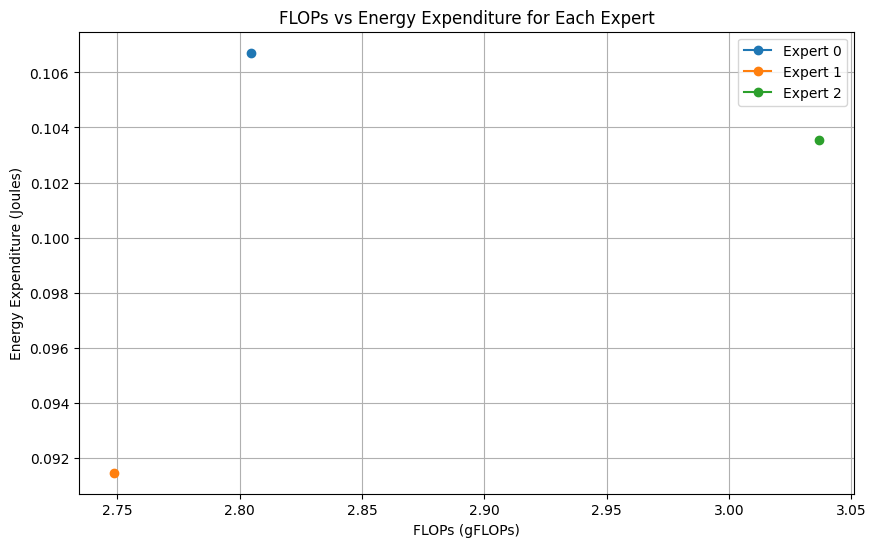

Layer 5 Energy in joules:  14.202740478515624
Layer  5
  Expert 0: 0.0764 J
  Expert 0: 2.3940 gFlops
  Expert 1: 0.0693 J
  Expert 1: 3.2895 gFlops
  Expert 2: 0.0828 J
  Expert 2: 2.9064 gFlops


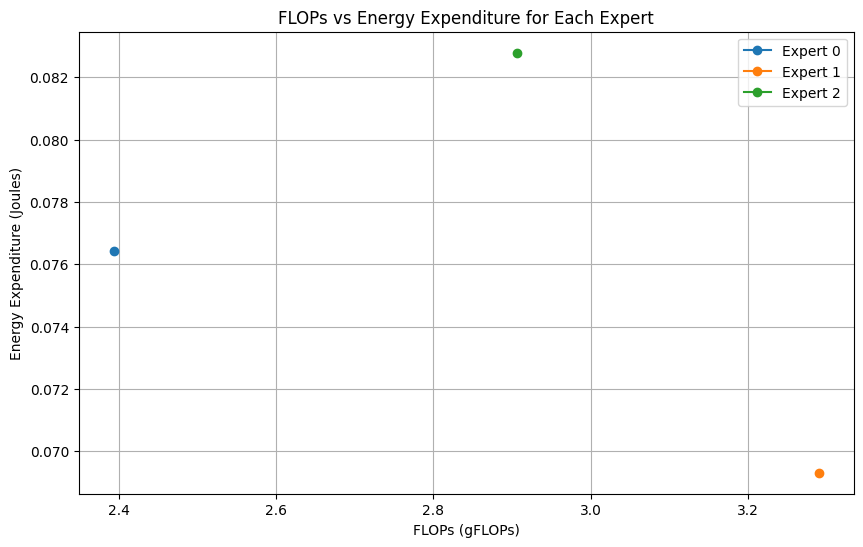

Layer 6 Energy in joules:  13.417918519973755
Layer  6
  Expert 0: 0.0728 J
  Expert 0: 2.8903 gFlops
  Expert 1: 0.0719 J
  Expert 1: 3.1122 gFlops
  Expert 2: 0.0709 J
  Expert 2: 2.5874 gFlops


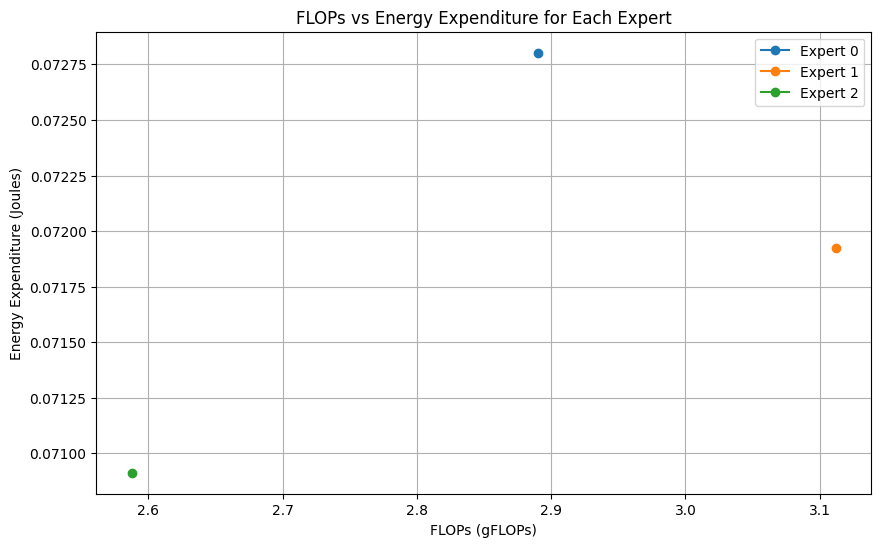

Layer 7 Energy in joules:  13.361561522483827
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.090081990734376
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.0750 J
  Expert 0: 3.3959 gFlops
  Expert 1: 0.0761 J
  Expert 1: 2.5422 gFlops
  Expert 2: 0.1117 J
  Expert 2: 2.6518 gFlops


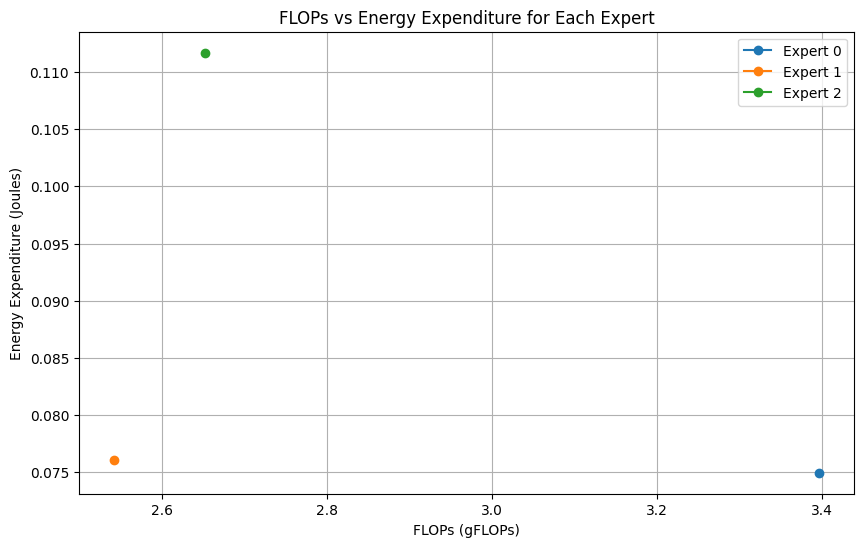

Layer 2 Energy in joules:  20.83154653787613
Layer  2
  Expert 0: 0.0854 J
  Expert 0: 3.0136 gFlops
  Expert 1: 0.1052 J
  Expert 1: 2.4923 gFlops
  Expert 2: 0.0966 J
  Expert 2: 3.0841 gFlops


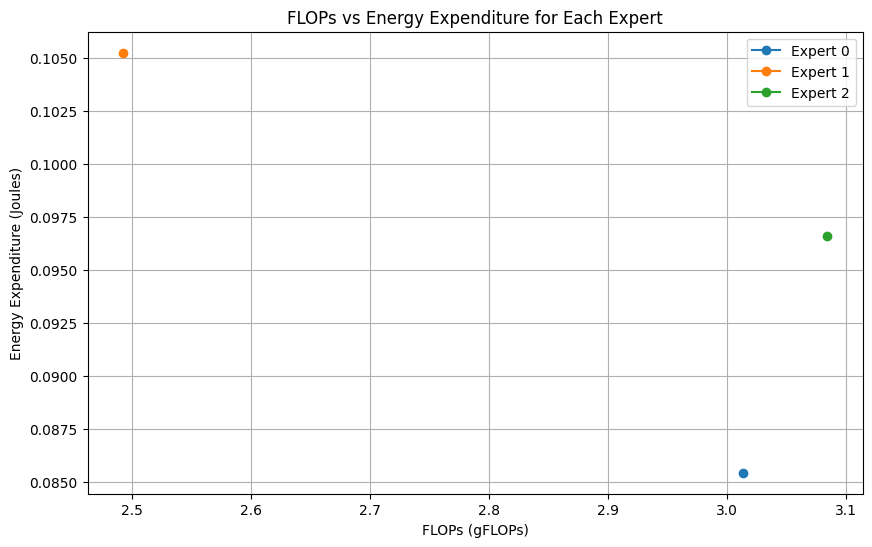

Layer 3 Energy in joules:  19.62412553548813
Layer  3
  Expert 0: 0.0914 J
  Expert 0: 2.6000 gFlops
  Expert 1: 0.1016 J
  Expert 1: 3.2466 gFlops
  Expert 2: 0.0918 J
  Expert 2: 2.7433 gFlops


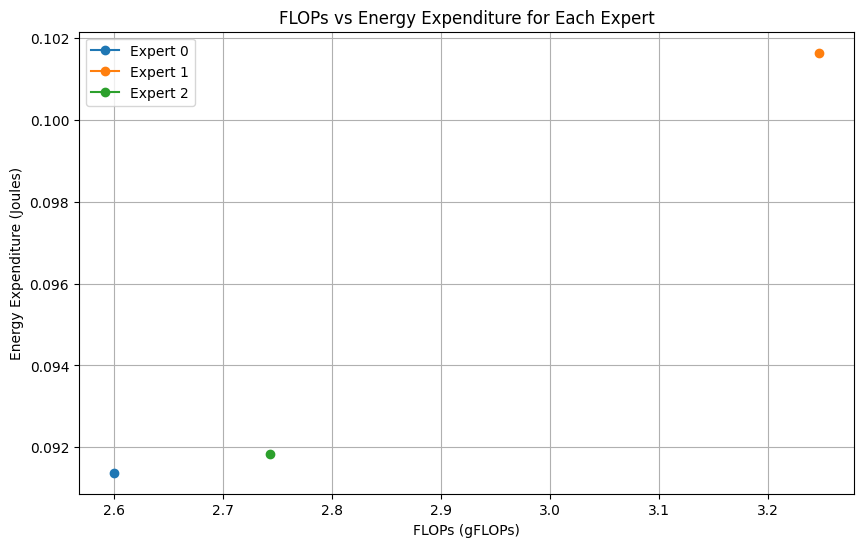

Layer 4 Energy in joules:  18.34383472919464
Layer  4
  Expert 0: 0.1021 J
  Expert 0: 2.8318 gFlops
  Expert 1: 0.1180 J
  Expert 1: 2.7150 gFlops
  Expert 2: 0.1105 J
  Expert 2: 3.0432 gFlops


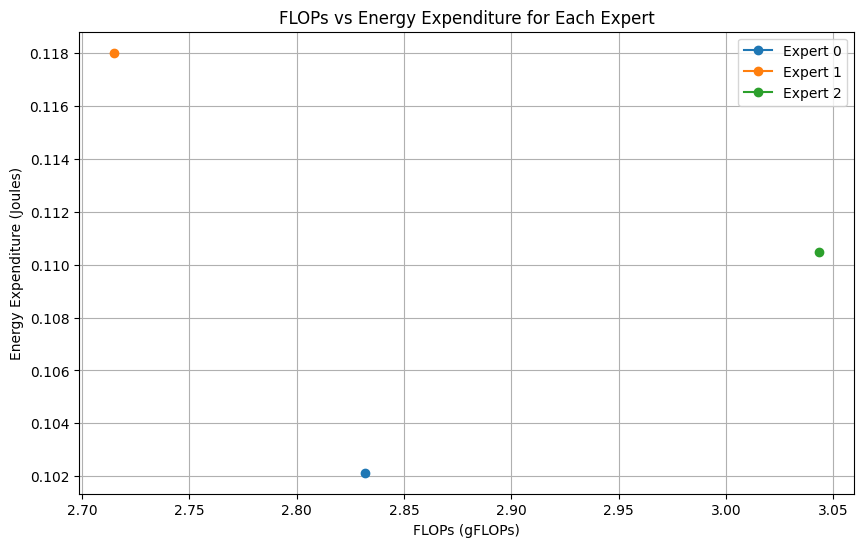

Layer 5 Energy in joules:  19.173153755664828
Layer  5
  Expert 0: 0.0679 J
  Expert 0: 2.3962 gFlops
  Expert 1: 0.0750 J
  Expert 1: 3.2829 gFlops
  Expert 2: 0.0705 J
  Expert 2: 2.9108 gFlops


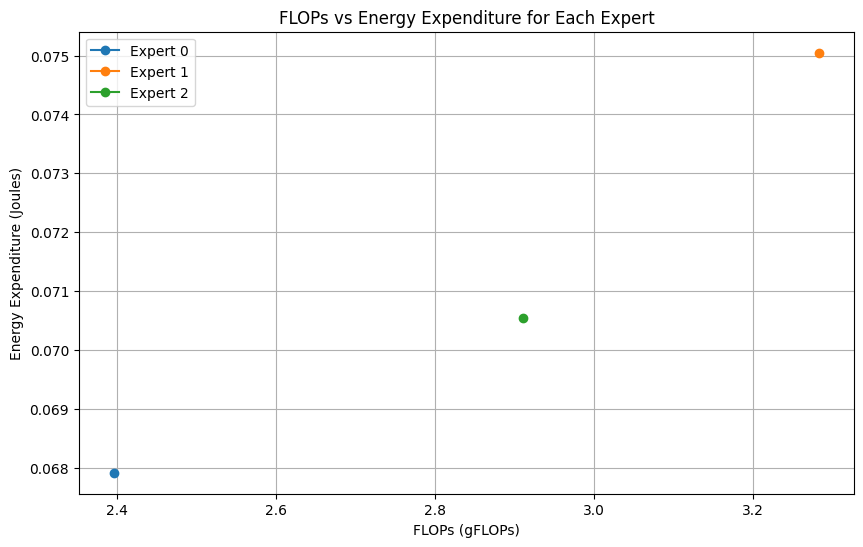

Layer 6 Energy in joules:  13.374084856510162
Layer  6
  Expert 0: 0.0689 J
  Expert 0: 2.8744 gFlops
  Expert 1: 0.0612 J
  Expert 1: 3.1711 gFlops
  Expert 2: 0.0606 J
  Expert 2: 2.5445 gFlops


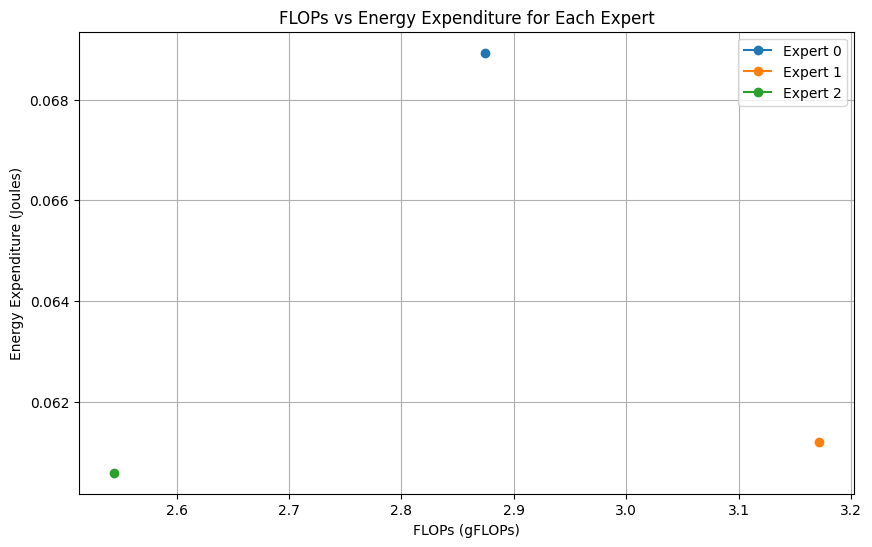

Layer 7 Energy in joules:  13.101582083702088
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.090081990734376
Layer 3 Gflops: 12.090081990734376
Layer 4 Gflops: 12.090081990734376
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.0786 J
  Expert 0: 3.3928 gFlops
  Expert 1: 0.0753 J
  Expert 1: 2.5452 gFlops
  Expert 2: 0.0732 J
  Expert 2: 2.6519 gFlops


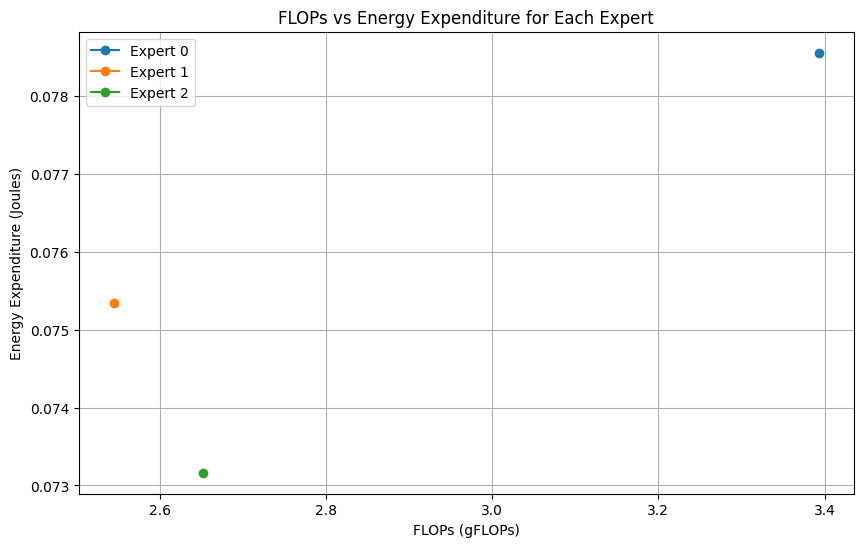

Layer 2 Energy in joules:  16.096567964553834
Layer  2
  Expert 0: 0.0924 J
  Expert 0: 3.0151 gFlops
  Expert 1: 0.0887 J
  Expert 1: 2.4868 gFlops
  Expert 2: 0.0816 J
  Expert 2: 3.0880 gFlops


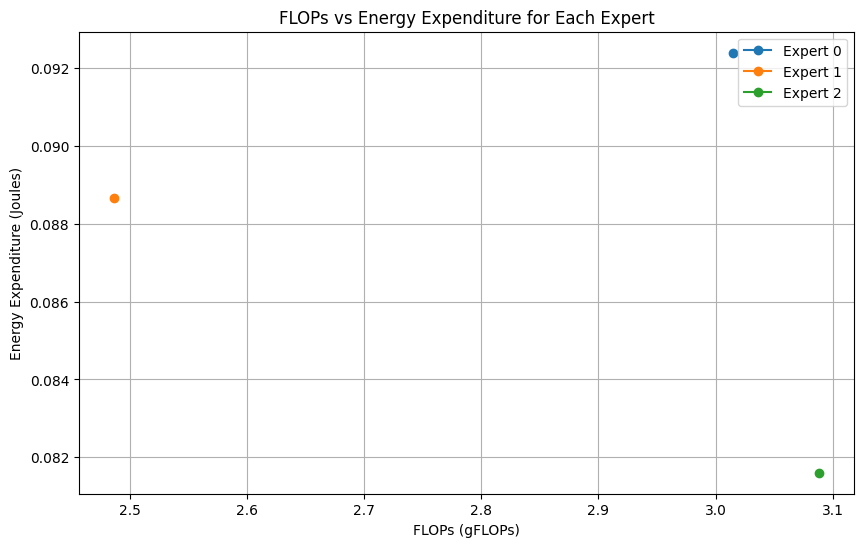

Layer 3 Energy in joules:  16.832337307929993
Layer  3
  Expert 0: 0.0774 J
  Expert 0: 2.6386 gFlops
  Expert 1: 0.0905 J
  Expert 1: 3.2228 gFlops
  Expert 2: 0.0809 J
  Expert 2: 2.7286 gFlops


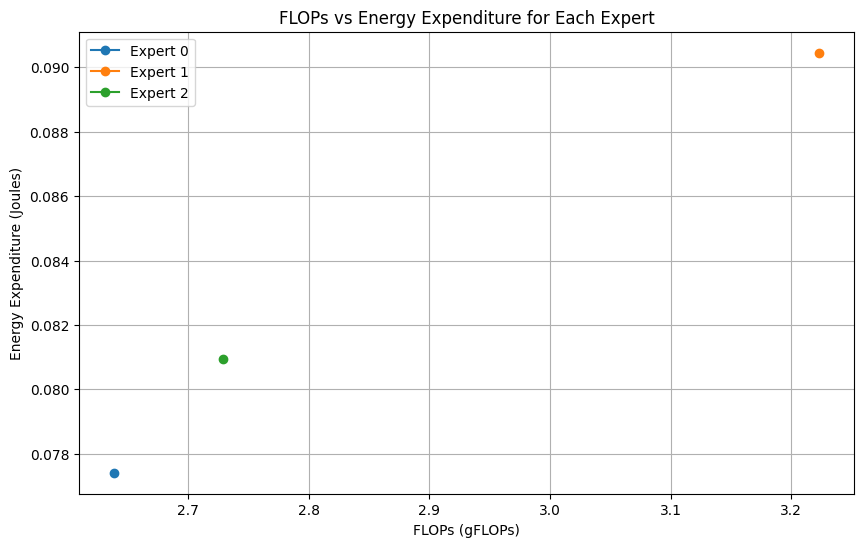

Layer 4 Energy in joules:  17.551078486442567
Layer  4
  Expert 0: 0.0698 J
  Expert 0: 2.8660 gFlops
  Expert 1: 0.0768 J
  Expert 1: 2.6823 gFlops
  Expert 2: 0.0695 J
  Expert 2: 3.0416 gFlops


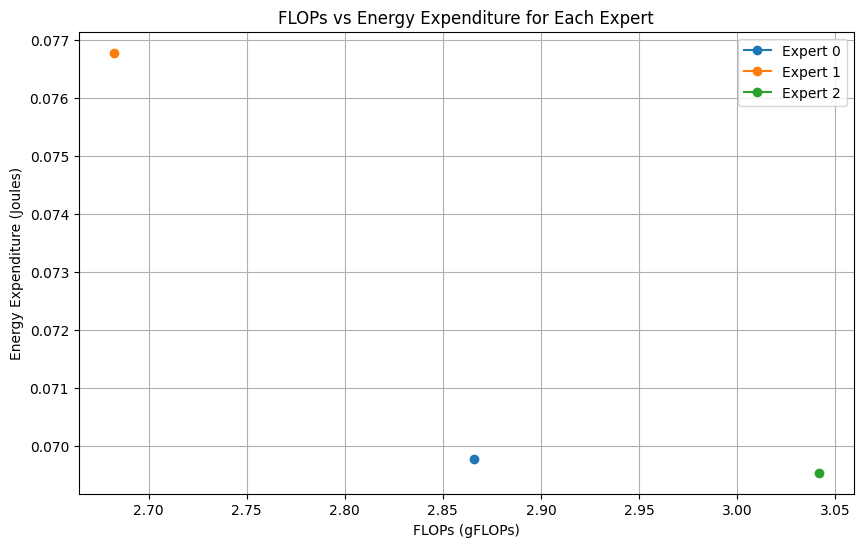

Layer 5 Energy in joules:  16.88915688991547
Layer  5
  Expert 0: 0.0603 J
  Expert 0: 2.4005 gFlops
  Expert 1: 0.0654 J
  Expert 1: 3.2748 gFlops
  Expert 2: 0.0635 J
  Expert 2: 2.9147 gFlops


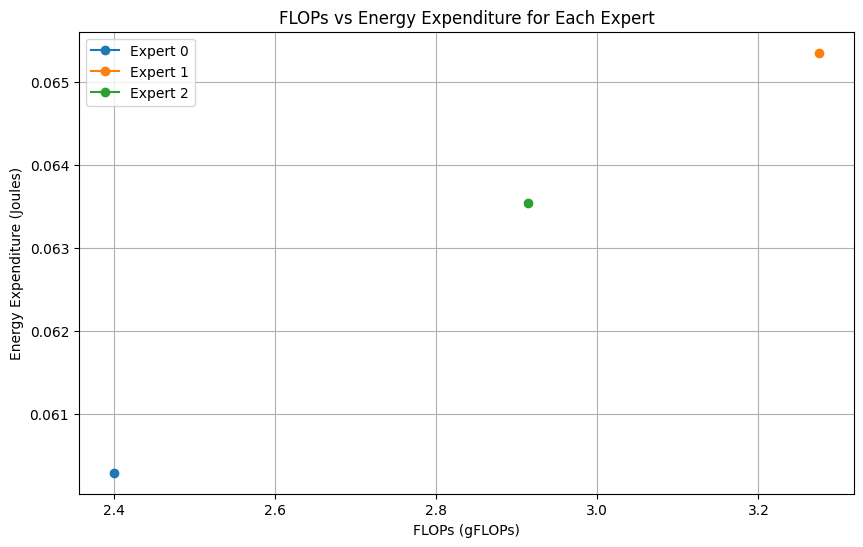

Layer 6 Energy in joules:  13.46840735435486
Layer  6
  Expert 0: 0.0555 J
  Expert 0: 2.8700 gFlops
  Expert 1: 0.0563 J
  Expert 1: 3.2050 gFlops
  Expert 2: 0.0617 J
  Expert 2: 2.5149 gFlops


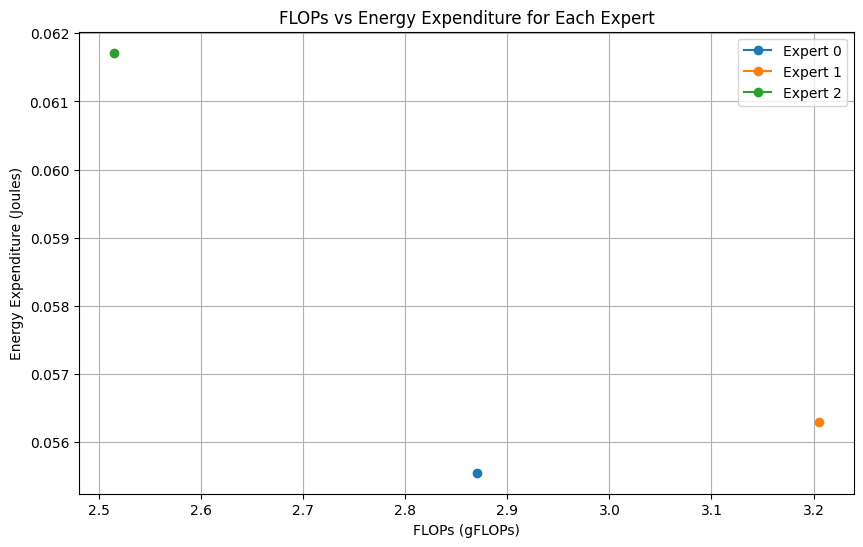

Layer 7 Energy in joules:  13.441377034187317
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.090080083385743
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Layer  1
  Expert 0: 0.1014 J
  Expert 0: 3.3949 gFlops
  Expert 1: 0.1166 J
  Expert 1: 2.5379 gFlops
  Expert 2: 0.4055 J
  Expert 2: 2.6571 gFlops


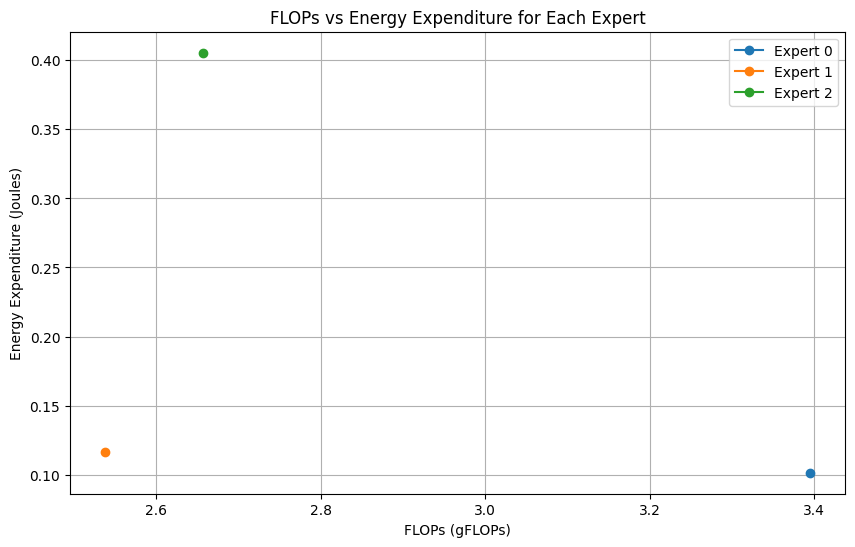

Layer 2 Energy in joules:  28.694359951019287
Layer  2
  Expert 0: 0.0860 J
  Expert 0: 3.0140 gFlops
  Expert 1: 0.0849 J
  Expert 1: 2.4762 gFlops
  Expert 2: 0.0859 J
  Expert 2: 3.0998 gFlops


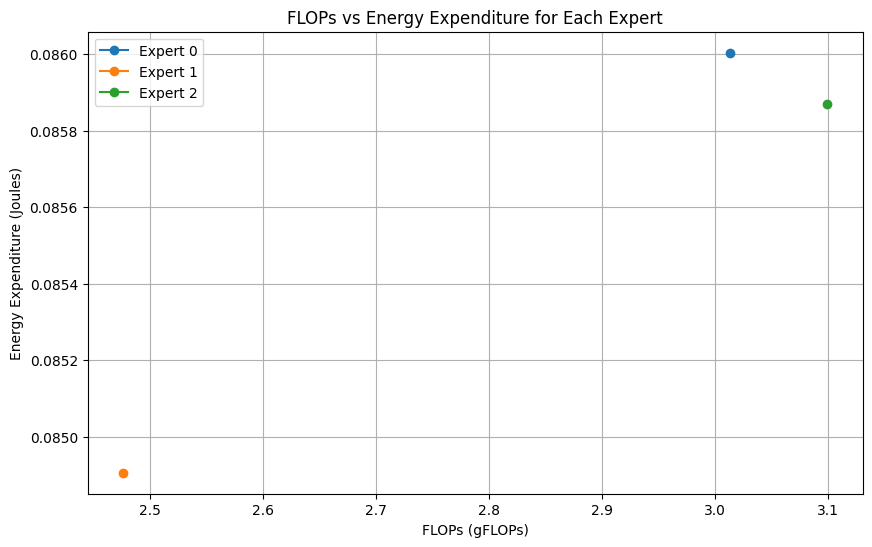

Layer 3 Energy in joules:  25.296382942199706
Layer  3
  Expert 0: 0.0901 J
  Expert 0: 2.6513 gFlops
  Expert 1: 0.0805 J
  Expert 1: 3.2113 gFlops
  Expert 2: 0.0867 J
  Expert 2: 2.7273 gFlops


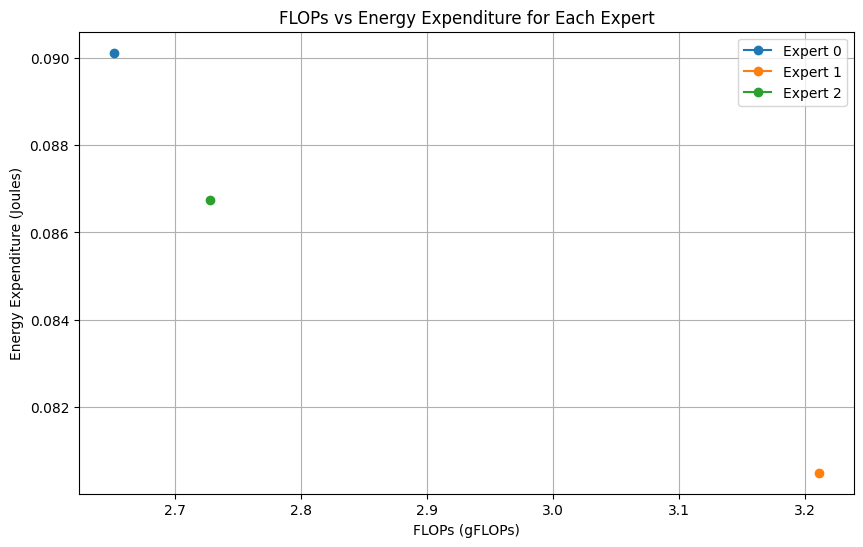

Layer 4 Energy in joules:  18.91947618961334
Layer  4
  Expert 0: 0.0626 J
  Expert 0: 2.8909 gFlops
  Expert 1: 0.0704 J
  Expert 1: 2.6489 gFlops
  Expert 2: 0.0642 J
  Expert 2: 3.0501 gFlops


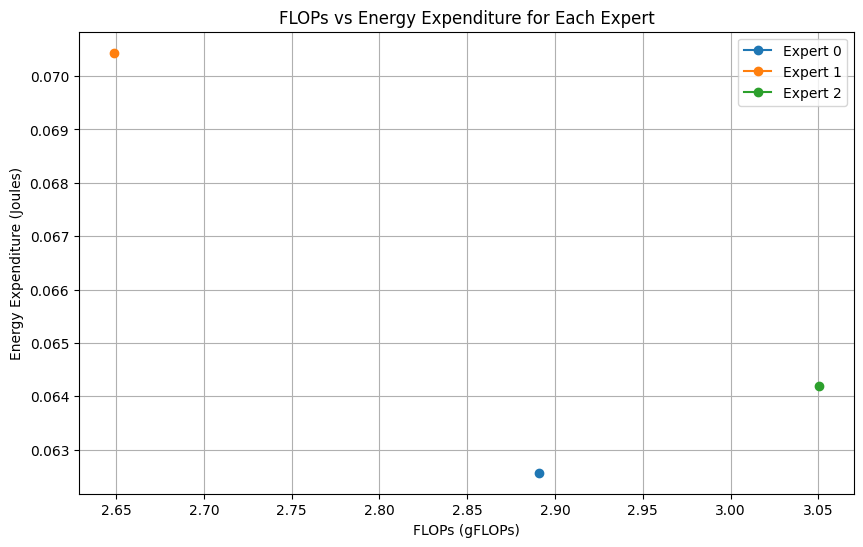

Layer 5 Energy in joules:  15.932075879573821
Layer  5
  Expert 0: 0.0603 J
  Expert 0: 2.3974 gFlops
  Expert 1: 0.0598 J
  Expert 1: 3.2611 gFlops
  Expert 2: 0.0546 J
  Expert 2: 2.9315 gFlops


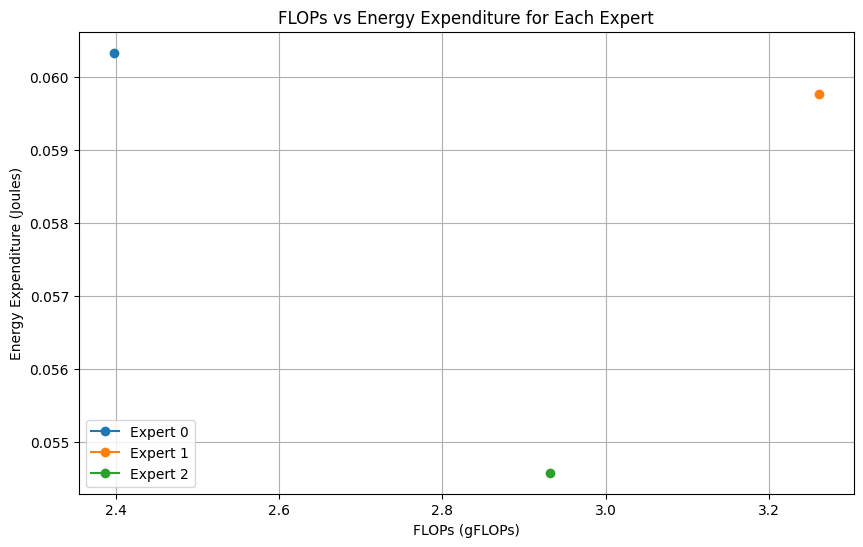

Layer 6 Energy in joules:  13.19526954650879
Layer  6
  Expert 0: 0.0517 J
  Expert 0: 2.8801 gFlops
  Expert 1: 0.0589 J
  Expert 1: 3.2167 gFlops
  Expert 2: 0.0593 J
  Expert 2: 2.4932 gFlops


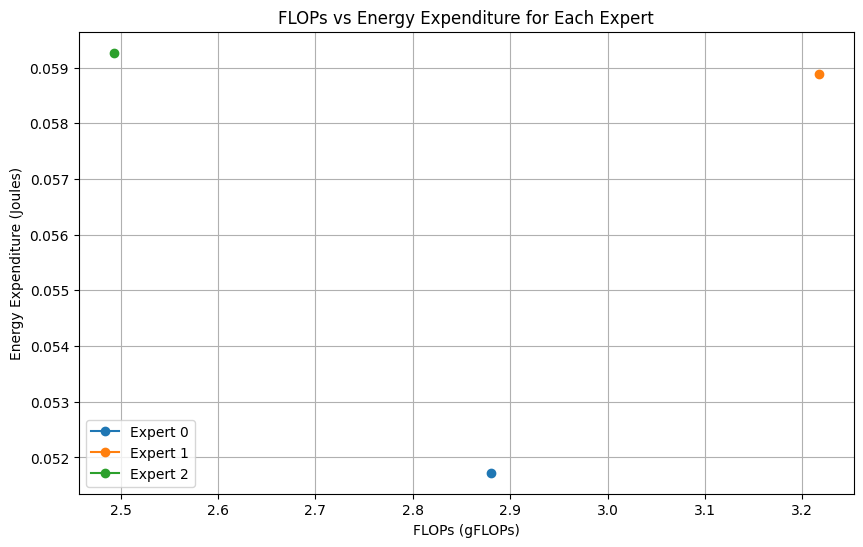

Layer 7 Energy in joules:  14.784808609485626
Layer 1 Gflops: 12.090081990734376
Layer 2 Gflops: 12.090081990734376
Layer 3 Gflops: 12.090081990734376
Layer 4 Gflops: 12.090081990734376
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Epoch 2/2, Loss: 8.621810754140219


In [62]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Create DataLoader
batch_size = 16
from torch.nn.utils.rnn import pad_sequence


def collate_fn(batch):
    # batch is a list of tensors (each tensor is a tokenized sequence)
    input_ids = [item[0] for item in batch]  # Access the tensor in each batch item

    # Find the maximum length in the batch
    # max_length = max(seq.size(0) for seq in input_ids)
    max_length = 256

    # Pad sequences to the maximum length in the batch
    padded_inputs = torch.stack([
        torch.cat([seq, torch.full((max_length - seq.size(0),), tokenizer.pad_token_id)])
        if seq.size(0) < max_length else seq[:max_length]
        for seq in input_ids
    ], dim=0)

    return {'input_ids': padded_inputs}


# Create DataLoader with custom collate_fn
dataloader = DataLoader(tokenized_data, batch_size=batch_size, shuffle=True,drop_last=True, collate_fn=collate_fn)
print(len(dataloader.dataset))

num_tokens = tokenizer.vocab_size
print("NUM_TOKENS ", num_tokens)
dim = 512
heads = 8
depth = 6  # Number of transformer layers
num_experts = 3 # Number of experts for MoE

# Initialize the SwitchTransformer
model = SwitchTransformer(num_tokens=num_tokens, dim=dim, heads=heads, depth=depth, num_experts=num_experts)

# Use CrossEntropyLoss for token prediction tasks
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# If using a learning rate scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    batch_flops=0

    for batch in dataloader:

        inputs = batch['input_ids'].to(device)

        # Forward pass
        optimizer.zero_grad()
        with torch.autograd.profiler.profile(use_cuda=True) as prof:
          outputs, flops = model(inputs)

        batchFlops = sum(flops)/depth
        # The model's output shape is (batch_size, seq_length, num_tokens)
        # shift targets for next-token prediction (language modeling)
        print(outputs.shape)
        logits = outputs[:, :-1, :].contiguous()
        targets = inputs[:, 1:].contiguous()
        loss = criterion(logits.view(-1, num_tokens), targets.view(-1))

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Update total loss
        total_loss += loss.item()
        #del loss, outputs

        # for i in range(inputs.size(0)):
        #     input_text = tokenizer.decode(inputs[i].tolist(), skip_special_tokens=True)
        #     #print(f"Input Text: {input_text}")

        #     # Extract the most likely token indices for the output
        #     top_token_indices = outputs[i].argmax(dim=-1)  # Shape: [seq_length]
        #     output_text = tokenizer.decode(top_token_indices.tolist(), skip_special_tokens=True)
        #     #print(f"Output Text: {output_text}")

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss/len(dataloader)}")

    # Step the learning rate scheduler, if any
    scheduler.step()